# Projet Webscraping Axel & Jeremie

Importation des bibliothèques

In [84]:
import requests
import pandas as pd
import json
from datetime import datetime
from datetime import date
from bs4 import BeautifulSoup
import numpy as np
import re

Premier test de requête sur l'API sur une seule ville (Paris) voir ce que ça donne

In [344]:
r = requests.get("https://nominatim.openstreetmap.org/?q=Paris&format=json")
r.json()

[{'place_id': 297417241,
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
  'osm_type': 'relation',
  'osm_id': 7444,
  'boundingbox': ['48.8155755', '48.902156', '2.224122', '2.4697602'],
  'lat': '48.8588897',
  'lon': '2.3200410217200766',
  'display_name': 'Paris, Île-de-France, France métropolitaine, France',
  'class': 'boundary',
  'type': 'administrative',
  'importance': 0.9417101715588673,
  'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/poi_boundary_administrative.p.20.png'},
 {'place_id': 298001902,
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
  'osm_type': 'relation',
  'osm_id': 71525,
  'boundingbox': ['48.8155755', '48.902156', '2.224122', '2.4697602'],
  'lat': '48.8534951',
  'lon': '2.3483915',
  'display_name': 'Paris, Île-de-France, France métropolitaine, France',
  'class': 'boundary',
  'type': 'administrative',
  'importance': 0.9417101715588673,
  'icon': 'https://nominati

Récupérer son adresse IP automatiquement puis trouver l'endroit de sa localisation.

On envoie une requete a une API ipify pour récupérer son adresse IP.

### Adresse IP

In [3]:
import requests
ip = requests.get('https://api.ipify.org').text

On trouve sa localisation par rapport a cette adresse IP

Nous n'avons pas réussi à trouver le bon outil afin récupérer par rapport à l'IP, la localisation de l'utilisateur. Nous passons donc par un site et on le scrappe en utilisant Sélénium. Bien que le résulat donné peut ne pas être précis, cela nous suffira pour calculer la distance entre la personne et l'hôtel. 
Pour résumer on scrappe l'IP que l'on trouve sur une API, et sur un autre site on scrappe le résultat de la localisation, on doit écrire l'IP trouvé dans une barre de recherche et récupérer la localisation en coordonées avec l'API OpenStreetMap.

In [4]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import time

In [5]:
options = webdriver.ChromeOptions() 
options.add_argument('-headless') 
options.add_argument('-no-sandbox') 
options.add_argument('-disable-dev-shm-usage') 
options.add_argument("enable-automation") 
options.add_argument("--window-size=1920,1080") 
options.add_argument("--disable-extensions") 
options.add_argument("--dns-prefetch-disable") 
options.add_argument("--disable-gpu")
#driver = webdriver.Chrome('/usr/local/bin/chromedriver', options = options)
driver = webdriver.Chrome('/Users/macbook/.wdm/drivers/chromedriver/mac64/108.0.5359.71/chromedriver', options = options)
#driver  = webdriver.Chrome(ChromeDriverManager().install())

web_link ="https://mon-adresse-ip.fr/localiser-une-adresse-ip/"
driver.get(web_link)
#On cherche la barre de recherche
search_bar=driver.find_element_by_xpath('/html/body/div[2]/section[1]/div/div/div[1]/form/div/div[1]/input')
#on rempli la barre de recherche par l'adresse Ip
search_bar.send_keys(ip)
bouton_research=driver.find_element_by_xpath("/html/body/div[3]/section[1]/div/div/div[1]/form/div/div[2]/button")
#On clique sur le bouton rechercher
bouton_research.click()
time.sleep(10)


### Localisation de la personne :

Localisation ville :

In [6]:
adresse = driver.find_element_by_xpath("/html/body/div[3]/section[1]/div/div/div[2]").text
adresse

"L'adresse IP 176.138.138.120 se situe à Le Perreux-sur-Marne, France"

Nettoyage du résultat

In [7]:
adresse= adresse.split("à ")[1]
adresse

'Le Perreux-sur-Marne, France'

Localisation coordonnées de la ville trouvé

In [8]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")
location = geolocator.geocode(adresse)
print(location.latitude, location.longitude)

48.840627 2.5077111


# On stoppe le driver

In [9]:
driver.quit()

## Scrapper les 35 villes les plus touristiques :

On veut se concentrer sur les meilleures villes, les villes les plus touristiques de France. D'après le <a href="https://one-week-in.com/35-cities-to-visit-in-france/" target="_blank">One Week In.com</a> On a les 35 villes les plus visitées de France. Nous allons les scrapper

In [10]:
url        = "https://one-week-in.com/35-cities-to-visit-in-france/"
requesting = requests.get(url)
soup       = BeautifulSoup(requesting.content, "html.parser")

### Liste des villes à étudier sur le projet 

In [11]:
liste_element=soup.findAll('ol')[0].findAll('a')
cities_list = [place.text for place in liste_element]
cities_list

['Mont Saint Michel',
 'St Malo',
 'Bayeux',
 'Le Havre',
 'Rouen',
 'Paris',
 'Amiens',
 'Lille',
 'Strasbourg',
 'Chateau du Haut Koenigsbourg',
 'Colmar',
 'Eguisheim',
 'Besancon',
 'Dijon',
 'Annecy',
 'Grenoble',
 'Lyon',
 'Verdon Gorge',
 'Bormes les Mimosas',
 'Cassis',
 'Marseille',
 'Aix en Provence',
 'Avignon',
 'Uzès',
 'Nímes',
 'Aigues Mortes',
 'Saintes Maries de la mer',
 'Collioure',
 'Carcassonne',
 'Ariege',
 'Toulouse',
 'Montauban',
 'Biarritz',
 'Bayonne',
 'La Rochelle']

On applique maintenant sur la cities_list grâce à une loop pour obtenir les coordonées des villes grace a une API nominatim.openstreetmap

In [12]:
city_coordinate = []

for gps in cities_list:
    r = requests.get("https://nominatim.openstreetmap.org/search?q={}&format=json".format(gps))
    dic_gps = r.json()
    city_lat = float(dic_gps[0]['lat'])
    city_lon = float(dic_gps[0]['lon'])
    city_coordinate.append([city_lat,city_lon])

Petit visu du résultat des latitudes et longitudes obtenues

In [13]:
city_coordinate

[[48.6359541, -1.511459954959514],
 [48.649518, -2.0260409],
 [49.2764624, -0.7024738],
 [49.4938975, 0.1079732],
 [49.4404591, 1.0939658],
 [48.8588897, 2.3200410217200766],
 [49.8941708, 2.2956951],
 [50.6365654, 3.0635282],
 [48.584614, 7.7507127],
 [48.249489800000006, 7.34429620253195],
 [48.0777517, 7.3579641],
 [48.0447968, 7.3079618],
 [47.2380222, 6.0243622],
 [47.3215806, 5.0414701],
 [45.8992348, 6.1288847],
 [45.1875602, 5.7357819],
 [45.7578137, 4.8320114],
 [43.7496562, 6.3285616],
 [43.1506968, 6.3419285],
 [43.2140359, 5.5396318],
 [43.2961743, 5.3699525],
 [43.5298424, 5.4474738],
 [43.9492493, 4.8059012],
 [44.0121279, 4.4196718],
 [43.8374249, 4.3600687],
 [43.5658225, 4.1912837],
 [43.4522771, 4.4287172],
 [42.52505, 3.0831554],
 [43.2130358, 2.3491069],
 [42.9455368, 1.4065544156065486],
 [43.6044622, 1.4442469],
 [44.0175835, 1.3549991],
 [43.471143749999996, -1.552726590666314],
 [43.4945144, -1.4736657],
 [46.1591126, -1.1520434]]

On veut maintenant transformer notre cities_list en DataFrame et y ajouter les lat/lon concernées

In [14]:
df = pd.DataFrame(cities_list)
df.columns = ['Cities']
df.head()

,Cities
0,Mont Saint Michel
1,St Malo
2,Bayeux
3,Le Havre
4,Rouen


Comme pour la liste des villes, on convertit nos colonnes lat et lon (listes) en Dataframe

In [15]:
lat_lon = pd.DataFrame(city_coordinate)
lat_lon.columns = ['Latitude', 'Longitude']

lat_lon.head()

,Latitude,Longitude
0,48.635954,-1.511460
1,48.649518,-2.026041
2,49.276462,-0.702474
3,49.493898,0.107973
4,49.440459,1.093966


On associe notre DF lat_lon avec la colonne du nom des villes afin d'en faire un seul DF

In [16]:
lat_lon['Cities']=cities_list

In [17]:
lat_lon.head()

,Latitude,Longitude,Cities
0,48.635954,-1.511460,Mont Saint Michel
1,48.649518,-2.026041,St Malo
2,49.276462,-0.702474,Bayeux
3,49.493898,0.107973,Le Havre
4,49.440459,1.093966,Rouen


On réorganise l'ordre des colonnes pour un DF plus esthétique

In [18]:
lat_lon = lat_lon.iloc[:, [2,0,1]]
lat_lon.head()

,Cities,Latitude,Longitude
0,Mont Saint Michel,48.635954,-1.511460
1,St Malo,48.649518,-2.026041
2,Bayeux,49.276462,-0.702474
3,Le Havre,49.493898,0.107973
4,Rouen,49.440459,1.093966


In [19]:
# On récolte les colonnes importantes qui vont nous servir pour la future boucle

Latitude = lat_lon['Latitude'].tolist()
Longitude = lat_lon['Longitude'].tolist()

# Petit test sur les listes Latitude et Longitude voir ce que ça donnerait dans une loop
# On voit que la loop passe bien sur les 35 lignes concernées, on peut maintenant l'appliquer sur notre
# nouvel request (API météo)

# Données Météo :

Créer une boucle pour répéter la météo sur les 35 villes de la 'cities_list' grâce à l'API OpenWeatherMap


Clé de l'API OpenWeatherMap (à ne pas communiquer)

In [20]:
api_key = "918a35b1534d62a40849c70979c2e98b"

In [21]:
weather_json = []

for i in range(len(Latitude)):
    #print(Latitude[i], Longitude[i])
    # Le request qu'on fera agir sur l'URL de l'API
    r_weather = requests.get("https://api.openweathermap.org/data/2.5/onecall?lat={}&lon={}&units=metric&exclude=minutely,hourly,alerts&appid={}".format(Latitude[i], Longitude[i], api_key))  
    
    # Faire un requests pour essayer de saisir le JSON sur l'URL 
    dic_weather = r_weather.json()
    
    # Une nouvelle boucle est nécessaire pour répéter cette request maintenant sur 7j
    for week in range(1,8):
        Lat_ = float(lat_lon['Latitude'][i])
        Lon_ = float(lat_lon['Longitude'][i])
        Météo = dic_weather["daily"][week]["weather"][0]["description"]
        Température = dic_weather["daily"][week]["temp"]["day"]
        Humidité = dic_weather["daily"][week]["humidity"]
        Vent = dic_weather["daily"][week]["wind_speed"]
        Date = dic_weather['daily'][week]['dt']
        Timestamp = dic_weather['daily'][week]['dt']
        Date = datetime.fromtimestamp(int(Timestamp))

             # Dictionnaire pour la météo
        dictionnaire = {'Latitude': Lat_,
                        'Longitude': Lon_,
                        'Weather': Météo,
                        'Temperature': Température,
                        'Humidity': Humidité,
                        'Wind': Vent,
                        'Date': Date

                        }

    # récupération de tous les résultats
        weather_json.append(dictionnaire)
        

    

weather_json    

[{'Latitude': 48.6359541,
  'Longitude': -1.511459954959514,
  'Weather': 'overcast clouds',
  'Temperature': 7.04,
  'Humidity': 65,
  'Wind': 3.98,
  'Date': datetime.datetime(2023, 1, 20, 13, 0)},
 {'Latitude': 48.6359541,
  'Longitude': -1.511459954959514,
  'Weather': 'broken clouds',
  'Temperature': 4.17,
  'Humidity': 66,
  'Wind': 4.58,
  'Date': datetime.datetime(2023, 1, 21, 13, 0)},
 {'Latitude': 48.6359541,
  'Longitude': -1.511459954959514,
  'Weather': 'broken clouds',
  'Temperature': 4.54,
  'Humidity': 56,
  'Wind': 3.03,
  'Date': datetime.datetime(2023, 1, 22, 13, 0)},
 {'Latitude': 48.6359541,
  'Longitude': -1.511459954959514,
  'Weather': 'clear sky',
  'Temperature': 6.21,
  'Humidity': 70,
  'Wind': 3.3,
  'Date': datetime.datetime(2023, 1, 23, 13, 0)},
 {'Latitude': 48.6359541,
  'Longitude': -1.511459954959514,
  'Weather': 'few clouds',
  'Temperature': 4.98,
  'Humidity': 70,
  'Wind': 3.74,
  'Date': datetime.datetime(2023, 1, 24, 13, 0)},
 {'Latitude': 48

weather_json étant une liste, on le convertit en DF pour un tableau plus esthétique

In [22]:
weather_week = pd.DataFrame(weather_json)

# On a trouvé le temps sur 7j mais sans le nom des villes

weather_week

,Latitude,Longitude,Weather,Temperature,Humidity,Wind,Date
0,48.635954,-1.511460,overcast clouds,7.04,65,3.98,2023-01-20 13:00:00
1,48.635954,-1.511460,broken clouds,4.17,66,4.58,2023-01-21 13:00:00
2,48.635954,-1.511460,broken clouds,4.54,56,3.03,2023-01-22 13:00:00
3,48.635954,-1.511460,clear sky,6.21,70,3.30,2023-01-23 13:00:00
4,48.635954,-1.511460,few clouds,4.98,70,3.74,2023-01-24 13:00:00
...,...,...,...,...,...,...,...
240,46.159113,-1.152043,clear sky,4.75,55,6.47,2023-01-22 13:00:00
241,46.159113,-1.152043,few clouds,4.90,73,7.02,2023-01-23 13:00:00
242,46.159113,-1.152043,clear sky,4.72,69,6.42,2023-01-24 13:00:00
243,46.159113,-1.152043,clear sky,4.93,71,5.26,2023-01-25 13:00:00


On fait une jointure nécessaire pour relier les DF 'lat_lon' et 'weather_week'

In [160]:
final_result = pd.merge(lat_lon, weather_week, on=["Latitude", "Longitude"])

In [24]:
dic_weather.keys()

dict_keys(['lat', 'lon', 'timezone', 'timezone_offset', 'current', 'daily'])

# Tableau final de la météo des 35 villes (cities_list) sur 7j :

In [25]:
final_result

,Cities,Latitude,Longitude,Weather,Temperature,Humidity,Wind,Date
0,Mont Saint Michel,48.635954,-1.511460,overcast clouds,7.04,65,3.98,2023-01-20 13:00:00
1,Mont Saint Michel,48.635954,-1.511460,broken clouds,4.17,66,4.58,2023-01-21 13:00:00
2,Mont Saint Michel,48.635954,-1.511460,broken clouds,4.54,56,3.03,2023-01-22 13:00:00
3,Mont Saint Michel,48.635954,-1.511460,clear sky,6.21,70,3.30,2023-01-23 13:00:00
4,Mont Saint Michel,48.635954,-1.511460,few clouds,4.98,70,3.74,2023-01-24 13:00:00
...,...,...,...,...,...,...,...,...
240,La Rochelle,46.159113,-1.152043,clear sky,4.75,55,6.47,2023-01-22 13:00:00
241,La Rochelle,46.159113,-1.152043,few clouds,4.90,73,7.02,2023-01-23 13:00:00
242,La Rochelle,46.159113,-1.152043,clear sky,4.72,69,6.42,2023-01-24 13:00:00
243,La Rochelle,46.159113,-1.152043,clear sky,4.93,71,5.26,2023-01-25 13:00:00


# Exemple de prévision a Paris :

On a les prévisions des temperatures pour les 7 prochains jours.

In [26]:
ville="Paris"

In [27]:
prevision_paris=final_result[final_result["Cities"]==ville]
prevision_paris

,Cities,Latitude,Longitude,Weather,Temperature,Humidity,Wind,Date
35,Paris,48.85889,2.320041,broken clouds,4.84,71,4.45,2023-01-20 13:00:00
36,Paris,48.85889,2.320041,scattered clouds,3.40,62,4.80,2023-01-21 13:00:00
37,Paris,48.85889,2.320041,clear sky,3.48,51,4.66,2023-01-22 13:00:00
38,Paris,48.85889,2.320041,overcast clouds,3.70,74,3.52,2023-01-23 13:00:00
39,Paris,48.85889,2.320041,clear sky,4.26,63,3.68,2023-01-24 13:00:00
40,Paris,48.85889,2.320041,few clouds,4.64,70,2.13,2023-01-25 13:00:00
41,Paris,48.85889,2.320041,light rain,4.27,87,3.31,2023-01-26 13:00:00


On met la date en index

In [28]:
prevision_paris.set_index("Date",inplace=True)

### Visualisation de l'évolution de la température sur une semaine

In [29]:
import matplotlib.pyplot as plt

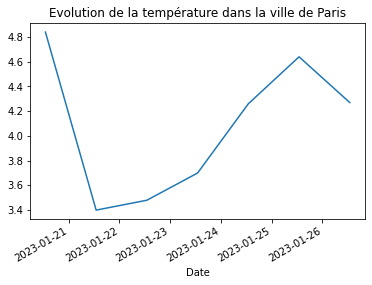

In [30]:
prevision_paris["Temperature"].plot()
plt.title(f"Evolution de la température dans la ville de {ville}")
plt.show()

### Visualisation de l'évolution de l'humidité sur une semaine

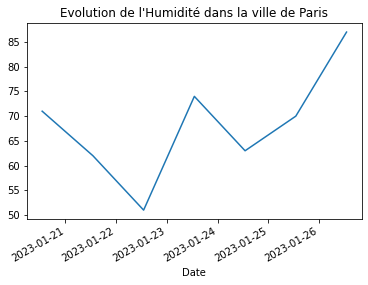

In [31]:
prevision_paris["Humidity"].plot()
plt.title(f"Evolution de l'Humidité dans la ville de {ville}")
plt.show()

### Visualisation de l'évolution du vent sur une semaine

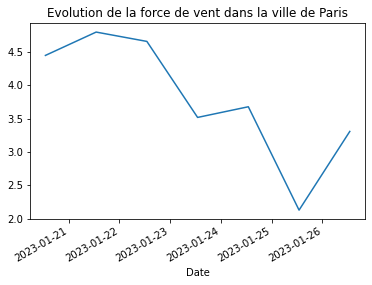

In [32]:
prevision_paris["Wind"].plot()
plt.title(f"Evolution de la force de vent dans la ville de {ville}")
plt.show()

On normalise les variables :

In [33]:
max_=prevision_paris[["Temperature","Humidity","Wind"]].max()
min_=prevision_paris[["Temperature","Humidity","Wind"]].min()

In [34]:
prevision_paris_normalized=(prevision_paris[["Temperature","Humidity","Wind"]]-min_)/(max_-min_)
prevision_paris_normalized

,Temperature,Humidity,Wind
Date,,,
2023-01-20 13:00:00,1.000000,0.555556,0.868914
2023-01-21 13:00:00,0.000000,0.305556,1.000000
2023-01-22 13:00:00,0.055556,0.000000,0.947566
2023-01-23 13:00:00,0.208333,0.638889,0.520599
2023-01-24 13:00:00,0.597222,0.333333,0.580524
2023-01-25 13:00:00,0.861111,0.527778,0.000000
2023-01-26 13:00:00,0.604167,1.000000,0.441948


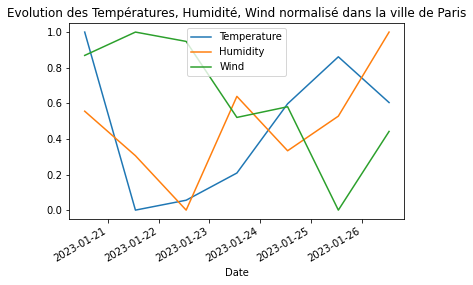

In [35]:
prevision_paris_normalized.plot()
plt.title(f"Evolution des Températures, Humidité, Wind normalisé dans la ville de {ville}")
plt.show()

Analyser la météo

## Prévision Météo dans la localisation de la personne :

Localisation de la personne

In [36]:
print(location.latitude, location.longitude)

48.840627 2.5077111


In [37]:
ville=location[0].split(",")[0]
ville

'Le Perreux-sur-Marne'

In [38]:
r_weather = requests.get("https://api.openweathermap.org/data/2.5/onecall?lat={}&lon={}&units=metric&exclude=minutely,hourly,alerts&appid={}".format(Lat_, Lon_, api_key))  

dic_weather = r_weather.json()

prevision_json = []

week_prevision=dic_weather["daily"]
week_prevision

for day in week_prevision:
    Météo = day["weather"][0]["description"]
    Température = day["temp"]["day"]
    Humidité = day["humidity"]
    Vent = day["wind_speed"]
    Date = day['dt']
    Timestamp = day['dt']
    Date = datetime.fromtimestamp(int(Timestamp))
    
    dictionnaire = {'Latitude': Lat_,
                    'Longitude': Lon_,
                    'Weather': Météo,
                    'Temperature': Température,
                    'Humidity': Humidité,
                    'Wind': Vent,
                    'Date': Date

                    }
    prevision_json.append(dictionnaire)



### On transforme les résultats en Dataframe

In [39]:
location_prevision=pd.DataFrame(prevision_json)
location_prevision['city']=ville
location_prevision

,Latitude,Longitude,Weather,Temperature,Humidity,Wind,Date,city
0,46.159113,-1.152043,heavy intensity rain,5.60,91,10.91,2023-01-19 13:00:00,Le Perreux-sur-Marne
1,46.159113,-1.152043,overcast clouds,6.18,70,6.92,2023-01-20 13:00:00,Le Perreux-sur-Marne
2,46.159113,-1.152043,clear sky,4.43,78,7.16,2023-01-21 13:00:00,Le Perreux-sur-Marne
3,46.159113,-1.152043,clear sky,4.75,55,6.47,2023-01-22 13:00:00,Le Perreux-sur-Marne
4,46.159113,-1.152043,few clouds,4.90,73,7.02,2023-01-23 13:00:00,Le Perreux-sur-Marne
5,46.159113,-1.152043,clear sky,4.72,69,6.42,2023-01-24 13:00:00,Le Perreux-sur-Marne
6,46.159113,-1.152043,clear sky,4.93,71,5.26,2023-01-25 13:00:00,Le Perreux-sur-Marne
7,46.159113,-1.152043,light rain,5.08,78,4.49,2023-01-26 13:00:00,Le Perreux-sur-Marne


In [40]:
location_prevision.set_index("Date",inplace=True)

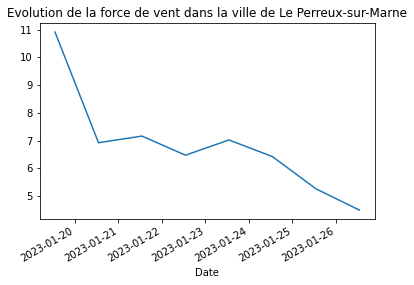

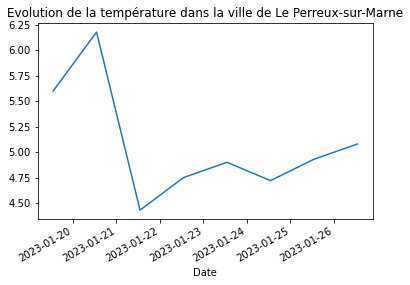

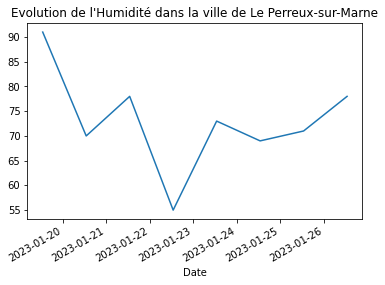

In [41]:
location_prevision["Wind"].plot()
plt.title(f"Evolution de la force de vent dans la ville de {ville}")
plt.show()
location_prevision["Temperature"].plot()
plt.title(f"Evolution de la température dans la ville de {ville}")
plt.show()
location_prevision["Humidity"].plot()
plt.title(f"Evolution de l'Humidité dans la ville de {ville}")
plt.show()

En normalisant

In [42]:
max_=location_prevision[["Temperature","Humidity","Wind"]].max()
min_=location_prevision[["Temperature","Humidity","Wind"]].min()

In [43]:
location_prevision_normalized=(location_prevision[["Temperature","Humidity","Wind"]]-min_)/(max_-min_)
location_prevision_normalized

,Temperature,Humidity,Wind
Date,,,
2023-01-19 13:00:00,0.668571,1.000000,1.000000
2023-01-20 13:00:00,1.000000,0.416667,0.378505
2023-01-21 13:00:00,0.000000,0.638889,0.415888
2023-01-22 13:00:00,0.182857,0.000000,0.308411
2023-01-23 13:00:00,0.268571,0.500000,0.394081
2023-01-24 13:00:00,0.165714,0.388889,0.300623
2023-01-25 13:00:00,0.285714,0.444444,0.119938
2023-01-26 13:00:00,0.371429,0.638889,0.000000


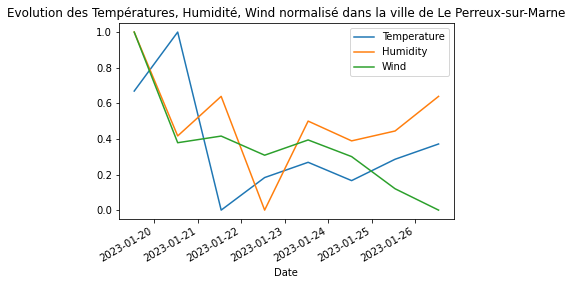

In [44]:
location_prevision_normalized.plot()
plt.title(f"Evolution des Températures, Humidité, Wind normalisé dans la ville de {ville}")
plt.show()

## Prediciton du meilleur moment pour partir

Généralement, le meilleur moment pour partir en voiture est le moment ou l'humidité et le vent sont les plus faibles. L'humidité et le vent ralentissent les voitures, la circulation, et augmente le danger et le temps de trajet. 
On déconseille aussi quand il y a de la neige et de la pluie, donc il faut vérifier la météo...

In [45]:
def find_best_moment_travel(dataframe):
    # Filter out rows where 'Weather' column contains 'rain' or 'snow'
    filtered_df = dataframe[~dataframe['Weather'].str.contains('rain|snow', case=False, na=False)]
    
    # Find the row with minimum values of 'Wind' and 'Humidity' columns
    best_line = filtered_df.sort_values(['Wind','Humidity'],ascending=[True,True])
    idx_0=best_line.index[0]
    
    #.loc[(filtered_df['Wind'] == filtered_df['Wind'].min()) & (filtered_df['Humidity'] == filtered_df['Humidity'].min())]
    
    return pd.DataFrame(best_line.loc[idx_0]).T


Pour transformer la météo en francais 

In [46]:
from googletrans import Translator
translator = Translator()

## Meilleur moment pour partir suivant votre localisation est :

In [47]:
meilleur_moment=find_best_moment_travel(location_prevision)
meilleur_moment

,Latitude,Longitude,Weather,Temperature,Humidity,Wind,city
2023-01-25 13:00:00,46.159113,-1.152043,clear sky,4.93,71,5.26,Le Perreux-sur-Marne


In [49]:
meilleur_moment=find_best_moment_travel(location_prevision)
print(f"Le meilleur moment pour partir en toute sécurité est le {meilleur_moment.index.strftime('%Y-%m-%d')[0]}")
print(f"La météo sera {translator.translate(meilleur_moment.Weather.values[0],src='en',dest='fr').text}")
print(f"La temperature sera de {meilleur_moment.Temperature.values[0]}")
print(f"L'humidité sera de {meilleur_moment.Humidity.values[0]}")
print(f"Le vent sera de {meilleur_moment.Wind.values[0]}")






Le meilleur moment pour partir en toute sécurité est le 2023-01-25
La météo sera ciel clair
La temperature sera de 4.93
L'humidité sera de 71
Le vent sera de 5.26


# Liste des villes avec la meilleur météo les 7 prochains jours

On va regarder dans le tableau des prévisions météo des 35 villes, les 5 villes les plus chaudes dans les 7 prochains jour. 

In [50]:
parametre='Temperature'

In [51]:
best_cities_list = final_result.groupby('Cities').agg({parametre: [max,np.mean]})
best_cities_list.columns

MultiIndex([('Temperature',  'max'),
            ('Temperature', 'mean')],
           )

In [52]:
best_cities_list.head()

Temperature          
                        max      mean
Cities                               
Aigues Mortes          8.50  7.144286
Aix en Provence        9.32  6.867143
Amiens                 6.00  4.250000
Annecy                 2.49  0.148571
Ariege                -2.23 -3.394286

Liste des 5 villes avec la meilleure température sur les 7 prochains jours, c'est a dire la moyenne de température la plus élevée.

In [53]:
best_five = best_cities_list.sort_values([("Temperature", "mean")], ascending = False)

best_five = best_five.head()

best_five

Temperature          
                           max      mean
Cities                                  
Bormes les Mimosas       11.53  9.068571
Cassis                   10.77  8.641429
Marseille                 9.83  7.838571
Aigues Mortes             8.50  7.144286
Aix en Provence           9.32  6.867143

On peut changer les paramètres de recherches, et décider si on veut les meilleures destinations, avec le moins d'humidité ou de vent. 

On généralise la fonction en lui donnant une liste de colonne où effectuer l'agregation

In [54]:
def agregate_cities_parameters(dataset,parametre):
    if len(parametre)>0:
        best_cities_list = dataset.groupby('Cities').agg(dict(zip(parametre,len(parametre)*[[max,min,np.mean]])))
    else:
        return "erreur choose at least one parameter"
    return best_cities_list


Fonction pour trouver les meilleures villes suivant les paramètres que l'on veut.

In [55]:
def best_cities_parameters(dataset,parametre,temperature_param="max",humidity_param="min",wind_param="min"):
    
    parametre_meteo_asc={"Temperature":False,"Humidity":True,"Wind":True}
    parametre_meteo={"Temperature":("Temperature", temperature_param),"Humidity":("Humidity", humidity_param),"Wind":("Wind", wind_param)}
    
    Ascending_list=pd.Series(parametre).map(parametre_meteo_asc).to_list()

    best_cities_list=agregate_cities_parameters(dataset,parametre)
    
    if temperature_param=="mean" or humidity_param=="mean" or wind_param=="mean":
        best_cities_list=best_cities_list.sort_values(list(zip(parametre,len(parametre)*["mean"])), ascending = Ascending_list )
    else:        
        best_cities_list=best_cities_list.sort_values(pd.Series(parametre).map(parametre_meteo).to_list(), ascending = Ascending_list )

    best_five = best_cities_list.head()
    
    return best_five

### la température moyenne, maximale et minimale, des 35 villes, les 7 prochains jours

In [56]:
parametre=['Temperature']

In [57]:
best_cities_list=agregate_cities_parameters(final_result,parametre)

In [58]:
best_cities_list.head()

Temperature                
                        max   min      mean
Cities                                     
Aigues Mortes          8.50  6.02  7.144286
Aix en Provence        9.32  3.68  6.867143
Amiens                 6.00  3.24  4.250000
Annecy                 2.49 -1.94  0.148571
Ariege                -2.23 -4.81 -3.394286

### Liste des 5  villes avec les meilleures maximales de température les 7 prochains jours

In [59]:
best_cities_parameters(final_result,parametre)

Temperature                
                           max   min      mean
Cities                                        
Bormes les Mimosas       11.53  6.14  9.068571
Cassis                   10.77  5.89  8.641429
Marseille                 9.83  5.49  7.838571
Aix en Provence           9.32  3.68  6.867143
Aigues Mortes             8.50  6.02  7.144286

### Liste des 5  villes avec les meilleures moyennes de température les 7 prochains jours

In [60]:
best_cities_parameters(final_result,parametre,temperature_param="mean")

Temperature                
                           max   min      mean
Cities                                        
Bormes les Mimosas       11.53  6.14  9.068571
Cassis                   10.77  5.89  8.641429
Marseille                 9.83  5.49  7.838571
Aigues Mortes             8.50  6.02  7.144286
Aix en Provence           9.32  3.68  6.867143

### Liste des 5  villes avec le moins d'humidité et de vent les 7 prochains jours

In [61]:
parametre=['Humidity','Wind']

In [62]:
best_cities_list=agregate_cities_parameters(final_result,parametre)
best_cities_list.head()

Humidity                  Wind                
                     max min       mean    max   min      mean
Cities                                                        
Aigues Mortes         51  46  48.285714  11.38  4.80  8.187143
Aix en Provence       56  29  40.000000   9.69  1.93  4.044286
Amiens                92  63  74.428571   6.15  2.41  4.681429
Annecy                93  81  85.428571   3.20  1.20  2.030000
Ariege                93  79  86.000000   7.43  2.24  3.615714

On définit les paramètres météo c'est a dire suivant les paramètres que l'on choisi on met le parametre suivant que l'on choisit d'être optimal. Il va de soit que l'on veut avoir le max de température,le minimun d'humidité, et le minimun de vent. On doit aussi paramétriser l'ordre de tri car on veut un tableau des plus grandes températures au plus petites mais le vent et humidité du min au max. Donc on a pas le meme ascending. On doit mapper sur la liste de parametre pour être varriable

In [63]:
temperature_param="max"
humidity_param="min"
wind_param="min"
parametre_meteo={"Temperature":("Temperature", temperature_param),"Humidity":("Humidity", humidity_param),"Wind":("Wind", wind_param)}
parametre_meteo_asc={"Temperature":False,"Humidity":True,"Wind":True}


### Liste des 5  villes avec les plus faibles humidités, vents, les 7 prochains jours 

In [64]:
best_cities_list.sort_values(pd.Series(parametre).map(parametre_meteo).to_list(), ascending = pd.Series(parametre).map(parametre_meteo_asc).to_list()).head()

Humidity                  Wind                
                        max min       mean    max   min      mean
Cities                                                           
Verdon Gorge             56  14  34.000000   4.15  1.59  2.370000
Aix en Provence          56  29  40.000000   9.69  1.93  4.044286
Bormes les Mimosas       64  31  44.857143   7.30  2.74  4.277143
Cassis                   65  31  42.857143  13.31  3.28  6.357143
Marseille                60  35  46.428571  14.73  4.54  7.724286

### Liste des 5  villes avec les meilleures humidités, vents, moyennant les 7 prochains jours 

In [65]:
best_cities_parameters(final_result,parametre,humidity_param="mean",wind_param="mean")

Humidity                  Wind                
                        max min       mean    max   min      mean
Cities                                                           
Verdon Gorge             56  14  34.000000   4.15  1.59  2.370000
Aix en Provence          56  29  40.000000   9.69  1.93  4.044286
Cassis                   65  31  42.857143  13.31  3.28  6.357143
Bormes les Mimosas       64  31  44.857143   7.30  2.74  4.277143
Marseille                60  35  46.428571  14.73  4.54  7.724286

### Liste des 5  villes avec les meilleures températures,humidités, vents, les 7 prochains jours 

In [66]:
parametre=['Temperature','Humidity','Wind']

In [67]:
best_cities_parameters(final_result,parametre,temperature_param="max",humidity_param="min",wind_param="min")

Temperature                 Humidity                  Wind  \
                           max   min      mean      max min       mean    max   
Cities                                                                          
Bormes les Mimosas       11.53  6.14  9.068571       64  31  44.857143   7.30   
Cassis                   10.77  5.89  8.641429       65  31  42.857143  13.31   
Marseille                 9.83  5.49  7.838571       60  35  46.428571  14.73   
Aix en Provence           9.32  3.68  6.867143       56  29  40.000000   9.69   
Aigues Mortes             8.50  6.02  7.144286       51  46  48.285714  11.38   

                                    
                     min      mean  
Cities                              
Bormes les Mimosas  2.74  4.277143  
Cassis              3.28  6.357143  
Marseille           4.54  7.724286  
Aix en Provence     1.93  4.044286  
Aigues Mortes       4.80  8.187143

### Liste des 5 villes avec les meilleures températures,humidités, vents, moyennant les 7 prochains jours 

In [68]:
best_cities_parameters(final_result,parametre,temperature_param="mean",humidity_param="mean",wind_param="mean")

Temperature                 Humidity                  Wind  \
                           max   min      mean      max min       mean    max   
Cities                                                                          
Bormes les Mimosas       11.53  6.14  9.068571       64  31  44.857143   7.30   
Cassis                   10.77  5.89  8.641429       65  31  42.857143  13.31   
Marseille                 9.83  5.49  7.838571       60  35  46.428571  14.73   
Aigues Mortes             8.50  6.02  7.144286       51  46  48.285714  11.38   
Aix en Provence           9.32  3.68  6.867143       56  29  40.000000   9.69   

                                    
                     min      mean  
Cities                              
Bormes les Mimosas  2.74  4.277143  
Cassis              3.28  6.357143  
Marseille           4.54  7.724286  
Aigues Mortes       4.80  8.187143  
Aix en Provence     1.93  4.044286

On voit que certaines villes changent en fonction du paramètre que l'on choisit

## Prediction de la meilleure date de réservation de vacances

Ici on essaye de prédire la meilleure date de vacances dans les 5 villes que l'on a trouvé. On va par rapport aux villes que l'on a trouvé regarder la date majoritaire qui à la moyenne la plus élevé sur la température et de vent et d'humidité la plus faible  

On paramétrise notre décision avec le parametre, ici on garde les 3 colonnes.

In [69]:
parametre=['Temperature', 'Humidity', 'Wind']

In [70]:
list_best_cities=best_cities_parameters(final_result,parametre,temperature_param="mean",humidity_param="mean",wind_param="mean")


In [71]:
list_best_cities.index

Index(['Bormes les Mimosas', 'Cassis', 'Marseille', 'Aigues Mortes',
       'Aix en Provence'],
      dtype='object', name='Cities')

In [72]:
tab_prevision_best_cities=final_result[final_result["Cities"].apply(lambda x: x in list_best_cities.index)]
tab_prevision_best_cities.head()

,Cities,Latitude,Longitude,Weather,Temperature,Humidity,Wind,Date
126,Bormes les Mimosas,43.150697,6.341928,rain and snow,6.16,34,7.30,2023-01-20 12:00:00
127,Bormes les Mimosas,43.150697,6.341928,broken clouds,6.14,31,5.00,2023-01-21 12:00:00
128,Bormes les Mimosas,43.150697,6.341928,scattered clouds,8.94,39,3.93,2023-01-22 12:00:00
129,Bormes les Mimosas,43.150697,6.341928,few clouds,9.67,39,2.74,2023-01-23 12:00:00
130,Bormes les Mimosas,43.150697,6.341928,light rain,10.03,51,2.95,2023-01-24 12:00:00


In [73]:
tab_mean=tab_prevision_best_cities.groupby("Date").mean()[parametre]
tab_mean

,Temperature,Humidity,Wind
Date,,,
2023-01-20 12:00:00,6.262,44.0,11.104
2023-01-21 12:00:00,5.688,39.2,8.692
2023-01-22 12:00:00,7.398,36.6,6.164
2023-01-23 12:00:00,8.042,38.4,4.424
2023-01-24 12:00:00,8.624,43.8,3.682
2023-01-25 12:00:00,9.592,50.8,4.008
2023-01-26 12:00:00,9.778,58.6,4.752


In [74]:
tab_mean.sort_values(parametre,ascending=[False,True,True])

,Temperature,Humidity,Wind
Date,,,
2023-01-26 12:00:00,9.778,58.6,4.752
2023-01-25 12:00:00,9.592,50.8,4.008
2023-01-24 12:00:00,8.624,43.8,3.682
2023-01-23 12:00:00,8.042,38.4,4.424
2023-01-22 12:00:00,7.398,36.6,6.164
2023-01-20 12:00:00,6.262,44.0,11.104
2023-01-21 12:00:00,5.688,39.2,8.692


In [75]:
tab_mean.sort_values(parametre,ascending=[False,True,True]).head(1)

,Temperature,Humidity,Wind
Date,,,
2023-01-26 12:00:00,9.778,58.6,4.752


In [76]:
best_date=tab_mean.sort_values(["Temperature","Humidity","Wind"],ascending=[False,True,True]).head(1).index.strftime('%Y-%m-%d')[0]
print(f"La meilleure date pour réserver dans les 7 prochains jour est {best_date} suivant les paramètres : ", ", ".join(parametre))



La meilleure date pour réserver dans les 7 prochains jours est 2023-01-26 suivant les paramètres :  Temperature, Humidity, Wind


## Prediction avec la météo
Un autre moyen est de compter par jour le nombre de météo identique, et de voir quel jour clear sky est la météo majoritaire.

In [77]:
tab_meteo=tab_prevision_best_cities.groupby(["Date","Weather"]).count()
tab_meteo

Cities  Latitude  Longitude  \
Date                Weather                                         
2023-01-20 12:00:00 light snow             1         1          1   
                    rain and snow          4         4          4   
2023-01-21 12:00:00 broken clouds          1         1          1   
                    clear sky              3         3          3   
                    few clouds             1         1          1   
2023-01-22 12:00:00 broken clouds          1         1          1   
                    few clouds             1         1          1   
                    scattered clouds       3         3          3   
2023-01-23 12:00:00 few clouds             2         2          2   
                    scattered clouds       3         3          3   
2023-01-24 12:00:00 broken clouds          1         1          1   
                    light rain             1         1          1   
                    overcast clouds        3         3          3   
2023-01-25 12:00:00 light rain             1         1          1   
                    overcast clouds        4         4          4   
2023-01-26 12:00:00 broken clouds          1         1          1   
                    clear sky              1         1          1   
                    few clouds             1         1          1   
                    scattered clouds       2         2          2   

                                      Temperature  Humidity  Wind  
Date                Weather                                        
2023-01-20 12:00:00 light snow                  1         1     1  
                    rain and snow               4         4     4  
2023-01-21 12:00:00 broken clouds               1         1     1  
                    clear sky                   3         3     3  
                    few clouds                  1         1     1  
2023-01-22 12:00:00 broken clouds               1         1     1  
                    few clouds                  1         1     1  
                    scattered clouds            3         3     3  
2023-01-23 12:00:00 few clouds                  2         2     2  
                    scattered clouds            3         3     3  
2023-01-24 12:00:00 broken clouds               1         1     1  
                    light rain                  1         1     1  
                    overcast clouds             3         3     3  
2023-01-25 12:00:00 light rain                  1         1     1  
                    overcast clouds             4         4     4  
2023-01-26 12:00:00 broken clouds               1         1     1  
                    clear sky                   1         1     1  
                    few clouds                  1         1     1  
                    scattered clouds            2         2     2

In [78]:
best_meteo_day=tab_meteo.loc[tab_meteo.index.get_level_values("Weather") == "clear sky"].idxmax()[0][0].strftime('%Y-%m-%d')

In [79]:
print(f"La meilleure date pour réserver dans les 7 prochains jour est {best_meteo_day} suivant la météo")



La meilleure date pour réserver dans les 7 prochains jour est 2023-01-21 suivant la météo


# Scrapping Booking.com 

On scrappe les hotels des 5 villes avec le paramètre que l'on a choisi pour les 7 prochains jours. 

### On récupère le nom des villes qui ont les meilleurs paramètres que l'on a choisi précédement 

C'est sur ces villes que l'on va scrapper les Hotels sur Booking.com

In [80]:
best_five_list = list(best_cities_parameters(final_result,parametre,temperature_param="mean",humidity_param="mean",wind_param="mean").index)
best_five_list

['Bormes les Mimosas',
 'Cassis',
 'Marseille',
 'Aigues Mortes',
 'Aix en Provence']

On va scrapper avec Beautiful Soup en changeant l'adresse url pour scrapper les hotels de la page principale 

In [81]:
booking_list = []

for hotels in range(len(best_five_list)):
    villes = best_five_list[hotels]
    #Id = hotels
    r_booking = requests.get('https://www.booking.com/searchresults.fr.html?ss={}'.format(best_five_list[hotels]), headers = {'User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Mobile Safari/537.36'})
    soup = BeautifulSoup(r_booking.content)
    link=soup.a
    hotel_url = soup.select('a.f348c1e3be')
    hotels_url = [x.get('href') for x in hotel_url]
    hotel_description = [element.get_text().replace('\n','') for element in soup.find_all('div','d8eab2cf7f')]
    hotel_address = [element.get_text().replace('\n','') for element in soup.find_all('span','a51f4b5adb')]
    hotel_score = [element.get_text().replace('\n','') for element in soup.find_all('span','d8eab2cf7f f0d4d6a2f5 e46e88563a')]
    nom_hotel= [element.get_text().replace('\n','') for element in soup.find_all('h2','f9afbb0024 f0d4d6a2f5 fda3b74d0d')]
    
    booking_dict = {
                        'Cities': best_five_list,
                        'Hotels': nom_hotel,
                        'Hotels URL': hotels_url,
                        'Hotel addresses': hotel_address,
                        'Hotels description': hotel_description,
                        'Hotels rating': hotel_score

                        }

    # récupération de tous les résultats
    booking_list.append(booking_dict)

In [86]:
options = webdriver.ChromeOptions() 
#options.add_argument('-headless') 
options.add_argument('-no-sandbox') 
options.add_argument('-disable-dev-shm-usage') 
options.add_argument("enable-automation") 
options.add_argument("--window-size=1920,1080") 
options.add_argument("--disable-extensions") 
options.add_argument("--dns-prefetch-disable") 
options.add_argument("--disable-gpu")
#driver = webdriver.Chrome('/usr/local/bin/chromedriver', options = options)
driver = webdriver.Chrome('/Users/macbook/.wdm/drivers/chromedriver/mac64/108.0.5359.71/chromedriver', options = options)

web_link ='https://www.booking.com/searchresults.fr.html?ss={}'.format(best_five_list[4])
driver.get(web_link)

## Scrapping des hotels sur une seule ville, Exemple : Marseille

On a fait avec Beautiful soup avant mais on perd des informations, car certaines informations sont irrécupérables en HTML simple. Ici on scrappe avec sélénium qui nous permet de scrapper plus simplement. Surtout qu'on aura besoin de cela pour rajouter des pré-filtres pour le scrapping des hotels

In [88]:
list_hotels=[]
hotels_nom=driver.find_elements_by_class_name("dd023375f5")
url_hotels=driver.find_elements_by_class_name("dd023375f5")
addresses=driver.find_elements_by_class_name("a1fbd102d9")
descriptions=driver.find_elements_by_class_name("b1e6dd8416")[::2] 
avis=driver.find_elements_by_class_name("e46e88563a")
notes=driver.find_elements_by_class_name("d10a6220b4")

for elt in zip(hotels_nom,url_hotels,addresses,descriptions,avis,notes):
    nom=elt[0].text.split("\n")[0]
    lien=elt[1].find_elements_by_class_name('e13098a59f')[0].get_attribute("href")
    addresse=elt[2].text.split('Indiquer')[0]
    description=elt[3].find_elements_by_class_name("d8eab2cf7f")[-1].text
    avis=elt[4].text.strip()
    note=elt[5].text
    lepetitplus=re.sub(r"eP","e, P",elt[2].text.split('carte')[-1])
    
    hotel = {'Hotels' : nom, 'Hotels URL' : lien,"Hotel addresses":addresse, "Hotels descriptions": description,"Hotels opinions":avis,'Hotels ratings': note,"lepetitplus":lepetitplus}
    list_hotels.append(hotel)
    
driver.quit()

In [89]:
df_Hotels=pd.DataFrame(list_hotels)

On a le dataset du scrapping que l'on vient d'effectuer sur le site booking.com

In [90]:
df_Hotels

,Hotels,Hotels URL,Hotel addresses,Hotels descriptions,Hotels opinions,Hotels ratings,lepetitplus
0,Appartement Le Paradiso - Le charme et le calm...,https://www.booking.com/hotel/fr/appartement-l...,Aix-en-Provence,"Doté d'une terrasse, l'Appartement Le Paradiso...",Fabuleux,"9,0","0,8 km du centre"
1,Rdc Dans Villa Avec Jardin Centre Ville Aix En...,https://www.booking.com/hotel/fr/rdc-dans-vill...,Aix-en-Provence,Rdc Dans Villa Avec Jardin Centre Ville Aix En...,Superbe,"8,9","1,2 km du centre"
2,L'Appartement Mathilde,https://www.booking.com/hotel/fr/appartement-m...,"Centre historique d'Aix-en-Provence, Aix-en-Pr...",85 expériences vécues,Superbe,"8,9","0,5 km du centre"
3,Luxury apt at 2 steps from the historical center,https://www.booking.com/hotel/fr/luxury-apt-at...,Aix-en-Provence,"Located in Aix-en-Provence, 32 km from Marseil...",Fabuleux,"9,0",350 m du centre
4,JOURDAN,https://www.booking.com/hotel/fr/jourdan-aix-e...,Aix-en-Provence,17 expériences vécues,Superbe,"8,7","0,8 km du centre"
5,LE DIX Duplex historical center balcony with v...,https://www.booking.com/hotel/fr/le-dix-duplex...,"Centre historique d'Aix-en-Provence, Aix-en-Pr...",8 expériences vécues,Exceptionnel,10,"0,6 km du centre"
6,T2 Aix-en-Provence,https://www.booking.com/hotel/fr/t2-aix-en-pro...,Aix-en-Provence,23 expériences vécues,Note,"5,3","5,3 km du centre"
7,"Studio ensoleillé, typique centre historique, ...",https://www.booking.com/hotel/fr/studio-ensole...,"Centre historique d'Aix-en-Provence, Aix-en-Pr...",2 expériences vécues,Fabuleux,"9,2","0,6 km du centre"
8,Ma place au sud Aix centre,https://www.booking.com/hotel/fr/ma-place-au-s...,Aix-en-Provence,10 expériences vécues,Superbe,"8,6","0,6 km du centre"
9,Furnished apartment with balcony in the center...,https://www.booking.com/hotel/fr/furnished-apa...,"Centre historique d'Aix-en-Provence, Aix-en-Pr...",79 expériences vécues,Superbe,"8,8",50 m du centre


## Scrapping sur toutes les villes choisies

Avec Sélénium on va scrapper tous les hotels des 5 villes qui nous intéresse et de la premiere page associé a booking.com, suivant le pré filtre que l'on donne (ici aucun). 

In [101]:
def Scrapp_hotels(best_five_list):
    
    list_hotels=[]
    options = webdriver.ChromeOptions() 
    
    #options.add_argument('-headless') 
    options.add_argument('-no-sandbox') 
    options.add_argument('-disable-dev-shm-usage') 
    options.add_argument("enable-automation") 
    options.add_argument("--window-size=1920,1080") 
    options.add_argument("--disable-extensions") 
    options.add_argument("--dns-prefetch-disable") 
    options.add_argument("--disable-gpu")
    driver = webdriver.Chrome('/usr/local/bin/chromedriver', options = options)
    driver = webdriver.Chrome('/Users/macbook/.wdm/drivers/chromedriver/mac64/108.0.5359.71/chromedriver', options = options)
        
    
    for ville in best_five_list:
        

        web_link ='https://www.booking.com/searchresults.fr.html?ss={}'.format(ville)
       
        driver.get(web_link)
        
        
        hotels_nom=driver.find_elements_by_class_name("dd023375f5")
        url_hotels=driver.find_elements_by_class_name("dd023375f5")
        addresses=driver.find_elements_by_class_name("a1fbd102d9")
        descriptions=driver.find_elements_by_class_name("b1e6dd8416")[::2] 
        avis=driver.find_elements_by_class_name("e46e88563a")
        notes=driver.find_elements_by_class_name("d10a6220b4")
        
        for elt in zip(hotels_nom,url_hotels,addresses,descriptions,avis,notes):
            nom=elt[0].text.split("\n")[0]
            lien=elt[1].find_elements_by_class_name('e13098a59f')[0].get_attribute("href")
            addresse=elt[2].text.split('Indiquer')[0]
            description=elt[3].find_elements_by_class_name("d8eab2cf7f")[-1].text
            avis=elt[4].text.strip()
            note=elt[5].text
            lepetitplus=re.sub(r"eP","e, P",elt[2].text.split('carte')[-1])
            
            hotel = {'cities':ville,'Hotels' : nom, 'Hotels URL' : lien,"Hotel addresses":addresse, "Hotels descriptions": description,"Hotels opinions":avis,'Hotels ratings': note,"lepetitplus":lepetitplus}
            list_hotels.append(hotel)
            
        
        
        #driver.quit()
    
    return pd.DataFrame(list_hotels)


In [92]:
df_Hotels=Scrapp_hotels(best_five_list)

# Résultat Scrapping

In [102]:
df_Hotels

,cities,Hotels,Hotels URL,Hotel addresses,Hotels descriptions,Hotels opinions,Hotels ratings,lepetitplus
0,Bormes les Mimosas,Les Terrasses,https://www.booking.com/hotel/fr/les-terrasses...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, l'établissement Le...",Très bien,"8,4","1,1 km du centre"
1,Bormes les Mimosas,Appartement Bord de Mer La Faviere,https://www.booking.com/hotel/fr/apartement-la...,Bormes-les-Mimosas,"Rénové en janvier 2022, l'Apartement La Favier...",Très bien,"8,3",3 km du centre
2,Bormes les Mimosas,Magnifique maison de village clim vue mer 6 pers,https://www.booking.com/hotel/fr/magnifique-ma...,Bormes-les-Mimosas,La Magnifique maison de village clim vue mer 6...,Très bien,"8,4","100 m du centre, Plage à proximité"
3,Bormes les Mimosas,Le petit atelier,https://www.booking.com/hotel/fr/le-petit-atel...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, en Provence-Alpes-...",Superbe,"8,9","1,1 km du centre, Plage à proximité"
4,Bormes les Mimosas,Asklan,https://www.booking.com/hotel/fr/assklan.fr.ht...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, à seulement 200 mè...",Bien,"7,6","3,4 km du centre"
...,...,...,...,...,...,...,...,...
112,Aix en Provence,Best Western Le Galice Centre Ville,https://www.booking.com/hotel/fr/best-western-...,Aix-en-Provence,Situé à 10 minutes à pied du centre d’Aix-en-P...,Bien,"7,6","0,9 km du centre"
113,Aix en Provence,Les Quatre Dauphins,https://www.booking.com/hotel/fr/les-quatre-da...,"Centre historique d'Aix-en-Provence, Aix-en-Pr...",L'établissement Les Quatre Dauphins occupe un ...,Très bien,"8,2",450 m du centre
114,Aix en Provence,Résidence Les Académies Aixoise,https://www.booking.com/hotel/fr/residence-aix...,Aix-en-Provence,"Dotée d'un jardin et d'une terrasse, la Réside...",Bien,"7,1","3,3 km du centre"
115,Aix en Provence,Domaine Gaogaia,https://www.booking.com/hotel/fr/domaine-and-c...,"Aix-les-Milles, Aix-en-Provence",Situé à 2 km du village des Milles et à 8 km d...,Très bien,"8,4","5,3 km du centre"


## Data Cleaning 

On fait essentiellement du data cleaning dans la partie scrapping, mais j'ai oublié de transformer la colonne Hotels ratings en entier donc on le fait en post traitement. On doit aussi remplacer le 8,7 en 8.7 pour convertir.

In [189]:
df_Hotels["Hotels ratings"]=df_Hotels["Hotels ratings"].apply(lambda x:float(x.replace(',','.')))
df_Hotels.dtypes

cities                  object
Hotels                  object
Hotels URL              object
Hotel addresses         object
Hotels descriptions     object
Hotels opinions         object
Hotels ratings         float64
lepetitplus             object
Latitude               float64
Longitude              float64
dtype: object

### Affichage des 35 villes Scrapper

In [103]:
import plotly.express as px
from plotly import graph_objs as go
import plotly.io as pio
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE

In [135]:
list_column = ['Cities', 'Weather', 'Humidity','Wind']

fig = px.scatter_mapbox(final_result, 
                        lat="Latitude", 
                        lon="Longitude", 
                        color="Temperature", 
                        size="Latitude", 
                        zoom=3.5, 
                        mapbox_style = "carto-positron",
                        hover_data=list_column,title="Carte des 35 villes étudiées "
                    )
fig.show()

## Les 5 Villes que l'on choisi pour scrapper les hotels

In [136]:
list_column = ['Cities', 'Weather', 'Humidity','Wind']

focus_villes=final_result[final_result["Cities"].str.contains('|'.join(best_five_list))]
fig = px.scatter_mapbox(focus_villes, 
                        lat="Latitude", 
                        lon="Longitude", 
                        color="Temperature", 
                        size="Latitude", 
                        zoom=3.5, 
                        mapbox_style = "carto-positron",
                        hover_data=list_column,title="Carte des villes scrappées "
                    )
fig.show()

## Les 5 Villes que l'on choisi pour scrapper les hotels avec leur température moyenne 

In [137]:
list_column = ['Cities', 'Humidity','Wind']

focus_villes=final_result[final_result["Cities"].str.contains('|'.join(best_five_list))].groupby('Cities').mean()
focus_villes.reset_index(inplace=True)


fig = px.scatter_mapbox(focus_villes, 
                        lat="Latitude", 
                        lon="Longitude", 
                        color="Temperature", 
                        size="Latitude", 
                        zoom=3.5, 
                        mapbox_style = "carto-positron",
                        hover_data=list_column,title="Carte des villes scrappées "
                    )
fig.show()

## Les 5 Villes que l'on choisi pour scrapper les hotels avec leur température de demain 

In [161]:
from datetime import datetime, timedelta

tomorrow = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")

list_column = ['Cities', 'Humidity','Wind']
final_result["Date"]=final_result["Date"].apply(lambda x:x.strftime("%Y-%m-%d"))
focus_villes=final_result[(final_result["Cities"].str.contains('|'.join(best_five_list))) & (final_result["Date"]==tomorrow)]
focus_villes.reset_index(inplace=True)


fig = px.scatter_mapbox(focus_villes, 
                        lat="Latitude", 
                        lon="Longitude", 
                        color="Temperature", 
                        size="Latitude", 
                        zoom=3.5, 
                        mapbox_style = "carto-positron",
                        hover_data=list_column,title="Carte des villes scrappées "
                    )
fig.show()

Ajout de la localisation Hotels scrappé

On ne peut pas scrapper la localisation de l'hotel sur la page principale, on va devoir a chaque fois prendre le lien de l'hotel et scrapper sa géolocalisation sur la carte, sur l'icone. Nous aurions pu passer par sélénium mais on devra faire des opération en plus qui ne nous intérresse pas a coder. 

In [163]:
url_list = df_Hotels['Hotels URL'].tolist()

modified_url_list = []
for url in url_list:
    index = url.index('?')
    modified_url = url[:index]
    modified_url_list.append(modified_url)
    
url_list = modified_url_list

url_list

['https://www.booking.com/hotel/fr/les-terrasses-bormes-les-mimosas.fr.html',
 'https://www.booking.com/hotel/fr/apartement-la-faviere-bormes-les-mimosas.fr.html',
 'https://www.booking.com/hotel/fr/magnifique-maison-de-village-clim-vue-mer-8-pers.fr.html',
 'https://www.booking.com/hotel/fr/le-petit-atelier-bormes-les-mimosas1234567891011121314151617.fr.html',
 'https://www.booking.com/hotel/fr/assklan.fr.html',
 'https://www.booking.com/hotel/fr/la-lavandiere-bormes-les-mimosas.fr.html',
 'https://www.booking.com/hotel/fr/maison-vacance-medievale-bormes-les-mimosas-village.fr.html',
 'https://www.booking.com/hotel/fr/la-faviere-a-petit-prix.fr.html',
 'https://www.booking.com/hotel/fr/terrasse-sur-la-mer.fr.html',
 'https://www.booking.com/hotel/fr/appartement-bormes-les-mimosas-3-pieces-5-personnes-fr-1-251-371.fr.html',
 'https://www.booking.com/hotel/fr/paradis.fr.html',
 'https://www.booking.com/hotel/fr/poseidon-2-pieces-32-m2-piscine-et-garage-prive.fr.html',
 'https://www.book

Exemple pour un Hotel

In [54]:
import requests
from bs4 import BeautifulSoup

URL = 'https://www.booking.com/hotel/fr/la-lavandiere-bormes-les-mimosas.fr.html'
page = requests.get(URL)

soup = BeautifulSoup(page.content, "html.parser")
soup.findAll('p',{'class',"address address_clean"})[0].find('a').get('data-atlas-latlng')

'43.14385490,6.35181560'

On obtient sa localisation

Pour tous les hotels

In [ ]:
def scrap_hotel_location(url_list):
    start = time.time()
    adresses_json = []
    
    for URL in url_list:
        ID = i
        r_adresses = requests.get(URL)
        soup = BeautifulSoup(r_adresses.content, "html.parser")
        hotel_adresse=soup.findAll('p',{'class',"address address_clean"})[0].find('a').get('data-atlas-latlng')
        #print(hotel_adresse)
        adresse_lat = float(hotel_adresse.split(",")[0])
        adresse_lon = float(hotel_adresse.split(",")[1])
        adresses_json.append([adresse_lat,adresse_lon])
        
    adresses_json
    end = time.time()
    print('Elapsed time: {}'.format(end - start))
    
    # Conversion de notre liste de coordonnées en DF
    hotels_lat_lon = pd.DataFrame(adresses_json)
    return hotels_lat_lon

In [165]:
start = time.time()
adresses_json = []

for URL in url_list:
    ID = i
    r_adresses = requests.get(URL)
    soup = BeautifulSoup(r_adresses.content, "html.parser")
    hotel_adresse=soup.findAll('p',{'class',"address address_clean"})[0].find('a').get('data-atlas-latlng')
    #print(hotel_adresse)
    adresse_lat = float(hotel_adresse.split(",")[0])
    adresse_lon = float(hotel_adresse.split(",")[1])
    adresses_json.append([adresse_lat,adresse_lon])
    
adresses_json
end = time.time()
print('Elapsed time: {}'.format(end - start))

# Conversion de notre liste de coordonnées en DF
hotels_lat_lon = pd.DataFrame(adresses_json)

Elapsed time: 325.78946590423584


In [167]:
# On nomme nos colonnes pour pouvoir merger par la suite avec le DF précédent
hotels_lat_lon.columns = ['Latitude', 'Longitude']

hotels_lat_lon.columns

Index(['Latitude', 'Longitude'], dtype='object')

On merge les deux datasets sur l'index. Le nouveau 

In [172]:
df_Hotels = pd.merge(df_Hotels,hotels_lat_lon, left_index = True, right_index = True)

In [173]:
df_Hotels

,cities,Hotels,Hotels URL,Hotel addresses,Hotels descriptions,Hotels opinions,Hotels ratings,lepetitplus,Latitude,Longitude
0,Bormes les Mimosas,Les Terrasses,https://www.booking.com/hotel/fr/les-terrasses...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, l'établissement Le...",Très bien,"8,4","1,1 km du centre",43.144129,6.351490
1,Bormes les Mimosas,Appartement Bord de Mer La Faviere,https://www.booking.com/hotel/fr/apartement-la...,Bormes-les-Mimosas,"Rénové en janvier 2022, l'Apartement La Favier...",Très bien,"8,3",3 km du centre,43.126026,6.356755
2,Bormes les Mimosas,Magnifique maison de village clim vue mer 6 pers,https://www.booking.com/hotel/fr/magnifique-ma...,Bormes-les-Mimosas,La Magnifique maison de village clim vue mer 6...,Très bien,"8,4","100 m du centre, Plage à proximité",43.151608,6.341123
3,Bormes les Mimosas,Le petit atelier,https://www.booking.com/hotel/fr/le-petit-atel...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, en Provence-Alpes-...",Superbe,"8,9","1,1 km du centre, Plage à proximité",43.142501,6.349179
4,Bormes les Mimosas,Asklan,https://www.booking.com/hotel/fr/assklan.fr.ht...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, à seulement 200 mè...",Bien,"7,6","3,4 km du centre",43.122648,6.359466
...,...,...,...,...,...,...,...,...,...,...
112,Aix en Provence,Best Western Le Galice Centre Ville,https://www.booking.com/hotel/fr/best-western-...,Aix-en-Provence,Situé à 10 minutes à pied du centre d’Aix-en-P...,Bien,"7,6","0,9 km du centre",43.528031,5.434359
113,Aix en Provence,Les Quatre Dauphins,https://www.booking.com/hotel/fr/les-quatre-da...,"Centre historique d'Aix-en-Provence, Aix-en-Pr...",L'établissement Les Quatre Dauphins occupe un ...,Très bien,"8,2",450 m du centre,43.524909,5.450423
114,Aix en Provence,Résidence Les Académies Aixoise,https://www.booking.com/hotel/fr/residence-aix...,Aix-en-Provence,"Dotée d'un jardin et d'une terrasse, la Réside...",Bien,"7,1","3,3 km du centre",43.527240,5.404795
115,Aix en Provence,Domaine Gaogaia,https://www.booking.com/hotel/fr/domaine-and-c...,"Aix-les-Milles, Aix-en-Provence",Situé à 2 km du village des Milles et à 8 km d...,Très bien,"8,4","5,3 km du centre",43.496401,5.394397


## Carte des hotels scrappés colorisées en fonction de leur note

In [196]:
hotels_column = ['cities','Hotels']

fig = px.scatter_mapbox(df_Hotels, 
                        lat="Latitude", 
                        lon="Longitude", 
                        color="Hotels ratings", 
                        size="Longitude", 
                        zoom=3.5, 
                        mapbox_style = "carto-positron",
                        color_continuous_scale = "Plasma",
                        hover_data=hotels_column,
                    )
fig.show()

On voit que généralement les hotels les mieux notés sont proches de la plage.
Ici on a que les résulats de la première page de scrappe pour chaque ville.

## Quelques Stats :

In [192]:
a=df_Hotels.groupby('cities').mean().sort_values('Hotels ratings',ascending=False)
a

,Hotels ratings,Latitude,Longitude
cities,,,
Aigues Mortes,8.852000,43.568519,4.193345
Cassis,8.752174,43.215802,5.537129
Bormes les Mimosas,8.526316,43.135710,6.348121
Aix en Provence,8.116000,43.522822,5.439729
Marseille,7.936000,43.293345,5.379879


In [193]:
import seaborn as sns
import matplotlib.pyplot as plt

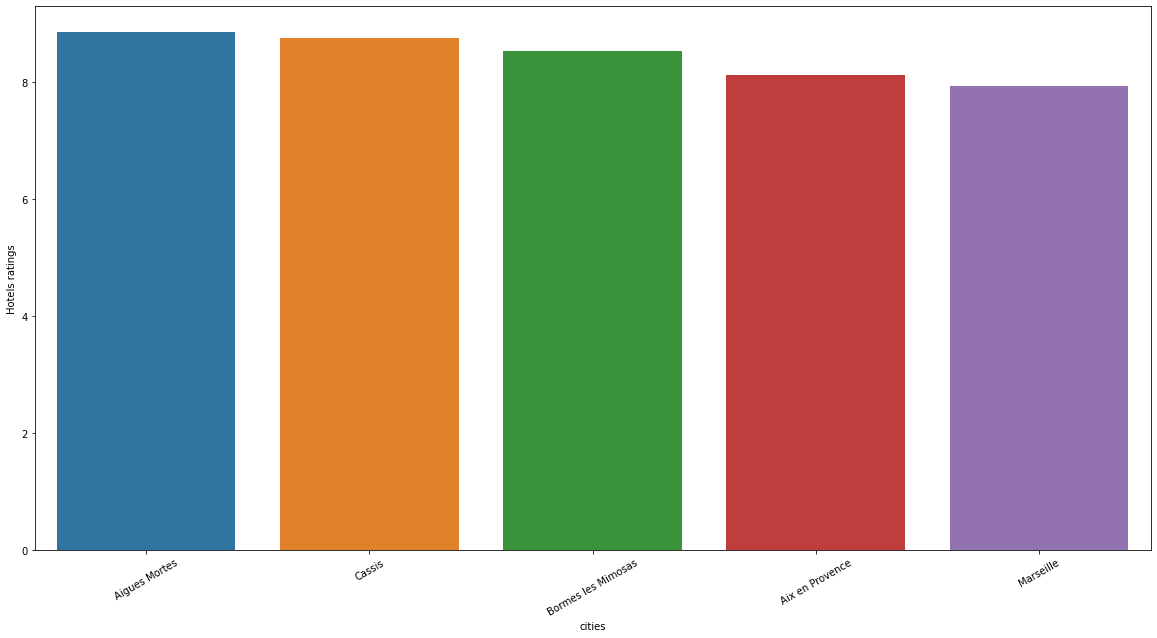

In [195]:
fig;ax = plt.subplots(figsize=(20,10))
ax=sns.barplot(x=a.index,y=a["Hotels ratings"])
plt.setp(ax.get_xticklabels(), rotation=30)
plt.show()

On va ajouter une colonne qui donne la distance entre la personne et chacun des hotels 

Pour rappel ma localisation

In [198]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")
location = geolocator.geocode(adresse)
print(location.latitude, location.longitude)

48.840627 2.5077111


In [202]:
from geopy.distance import distance
from geopy.point import Point


In [203]:
location_point = Point(location.latitude, location.longitude)

In [226]:
df_Hotels["distance (km)"]=list(map(lambda x : np.round(distance(location_point,Point(x[0], x[1])).km,2),df_Hotels[["Latitude","Longitude"]].values))



In [230]:
df_Hotels.head()

,cities,Hotels,Hotels URL,Hotel addresses,Hotels descriptions,Hotels opinions,Hotels ratings,lepetitplus,Latitude,Longitude,distance (km)
0,Bormes les Mimosas,Les Terrasses,https://www.booking.com/hotel/fr/les-terrasses...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, l'établissement Le...",Très bien,8.4,"1,1 km du centre",43.144129,6.351490,699.47
1,Bormes les Mimosas,Appartement Bord de Mer La Faviere,https://www.booking.com/hotel/fr/apartement-la...,Bormes-les-Mimosas,"Rénové en janvier 2022, l'Apartement La Favier...",Très bien,8.3,3 km du centre,43.126026,6.356755,701.49
2,Bormes les Mimosas,Magnifique maison de village clim vue mer 6 pers,https://www.booking.com/hotel/fr/magnifique-ma...,Bormes-les-Mimosas,La Magnifique maison de village clim vue mer 6...,Très bien,8.4,"100 m du centre, Plage à proximité",43.151608,6.341123,698.37
3,Bormes les Mimosas,Le petit atelier,https://www.booking.com/hotel/fr/le-petit-atel...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, en Provence-Alpes-...",Superbe,8.9,"1,1 km du centre, Plage à proximité",43.142501,6.349179,699.56
4,Bormes les Mimosas,Asklan,https://www.booking.com/hotel/fr/assklan.fr.ht...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, à seulement 200 mè...",Bien,7.6,"3,4 km du centre",43.122648,6.359466,701.92


## Fonction de Tri 

Tri sur la note 

In [233]:
df_Hotels.sort_values('Hotels ratings',ascending=False)

,cities,Hotels,Hotels URL,Hotel addresses,Hotels descriptions,Hotels opinions,Hotels ratings,lepetitplus,Latitude,Longitude,distance (km)
85,Aigues Mortes,AIGUES MARINES,https://www.booking.com/hotel/fr/aigues-marine...,Aigues-Mortes,"Offrant une vue sur le jardin, l'AIGUES MARINE...",Exceptionnel,9.7,"2,4 km du centre",43.558937,4.218141,601.70
89,Aigues Mortes,Chambre à 500 m des remparts,https://www.booking.com/hotel/fr/valerie-aigue...,Aigues-Mortes,"Dotée d'un jardin et d'une terrasse, la Chambr...",Exceptionnel,9.7,"1,2 km du centre",43.565819,4.205353,600.74
23,Cassis,Plage & Calanques Cassis,https://www.booking.com/hotel/fr/cote-calanque...,Cassis,Le Plage & Calanques Cassis est situé à Cassis...,Exceptionnel,9.7,"0,8 km du centre, Plage à proximité",43.212002,5.527630,667.75
12,Bormes les Mimosas,The Little House,https://www.booking.com/hotel/fr/the-little-ho...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, le FACE MER ENTRE ...",Superbe,9.6,"40 m du centre, Plage à proximité",43.150361,6.342202,698.53
29,Cassis,T2 VUE IMPRENABLE SUR CASSIS,https://www.booking.com/hotel/fr/t2-vue-impren...,Cassis,"Situé à Cassis, à 200 mètres de la Grande Mer,...",Exceptionnel,9.5,200 m du centre,43.214622,5.534773,667.67
...,...,...,...,...,...,...,...,...,...,...,...
49,Marseille,Ibis Marseille Centre Prefecture,https://www.booking.com/hotel/fr/premiere-clas...,"Castellane et Préfecture, Marseille",L’Ibis Marseille Centre Préfecture met à votre...,Bien,7.0,"0,8 km du centre, Proche du métro",43.291553,5.381971,655.53
91,Aigues Mortes,Noemys Aigues-Mortes - ex Mona Lisa Royal Hôtel,https://www.booking.com/hotel/fr/le-royal-hote...,Aigues-Mortes,Doté d'une connexion Wi-Fi gratuite et d'une p...,Bien,7.0,"1,2 km du centre",43.576396,4.197818,599.46
101,Aix en Provence,Odalys City Aix en Provence L'Atrium,https://www.booking.com/hotel/fr/atrium-d-anai...,Aix-en-Provence,"Situé à Aix-en-Provence, l’Odalys City Aix en ...",Note,6.9,"0,8 km du centre",43.524091,5.455216,633.13
10,Bormes les Mimosas,Hôtel Paradis,https://www.booking.com/hotel/fr/paradis.fr.ht...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, à 39 km de la gare...",Superbe,6.9,"0,9 km du centre, Plage à proximité",43.144686,6.335125,698.88


tri sur la distance

In [235]:
df_Hotels.sort_values('distance (km)',ascending=True)

,cities,Hotels,Hotels URL,Hotel addresses,Hotels descriptions,Hotels opinions,Hotels ratings,lepetitplus,Latitude,Longitude,distance (km)
72,Aigues Mortes,la cabane du saunier Stella - Etang du Roy,https://www.booking.com/hotel/fr/la-cabane-du-...,Aigues-Mortes,La cabane du saunier Stella - Etang du Roy est...,Exceptionnel,9.5,"2,3 km du centre",43.579302,4.212834,599.40
67,Aigues Mortes,Résidence Odalys Fleur de Sel,https://www.booking.com/hotel/fr/residence-oda...,Aigues-Mortes,"Situé à Aigues-Mortes, à 5 minutes à pied du c...",Très bien,8.3,"1,2 km du centre",43.574094,4.179246,599.41
68,Aigues Mortes,Résidence Odalys Le Mas des Flamants,https://www.booking.com/hotel/fr/residence-le-...,Aigues-Mortes,Située à l'extérieur des fortifications d'Aigu...,Très bien,8.0,"1,1 km du centre",43.573794,4.180622,599.46
91,Aigues Mortes,Noemys Aigues-Mortes - ex Mona Lisa Royal Hôtel,https://www.booking.com/hotel/fr/le-royal-hote...,Aigues-Mortes,Doté d'une connexion Wi-Fi gratuite et d'une p...,Bien,7.0,"1,2 km du centre",43.576396,4.197818,599.46
88,Aigues Mortes,Awesome home in Aigues-Mortes with 3 Bedrooms ...,https://www.booking.com/hotel/fr/three-bedroom...,Aigues-Mortes,"Offrant une vue sur la mer, l'Awesome home in ...",Exceptionnel,9.5,"0,8 km du centre",43.573889,4.186940,599.56
...,...,...,...,...,...,...,...,...,...,...,...
7,Bormes les Mimosas,A deux pas de la plage de la Faviere - Parking...,https://www.booking.com/hotel/fr/la-faviere-a-...,Bormes-les-Mimosas,Terrasse sur la mer is a property with a priva...,Exceptionnel 10,9.4,"3,2 km du centre",43.123358,6.352851,701.63
9,Bormes les Mimosas,"Appartement Bormes-les-Mimosas, 3 pièces, 5 pe...",https://www.booking.com/hotel/fr/appartement-b...,Bormes-les-Mimosas,Le POSEIDON - 2 pièces - 32 m2 - Piscine et ga...,Très bien,8.6,"3,3 km du centre, Plage à proximité",43.124432,6.361154,701.79
4,Bormes les Mimosas,Asklan,https://www.booking.com/hotel/fr/assklan.fr.ht...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, à seulement 200 mè...",Bien,7.6,"3,4 km du centre",43.122648,6.359466,701.92
14,Bormes les Mimosas,FACE MER ENTRE PLAGE ET MARINA,https://www.booking.com/hotel/fr/face-mer-entr...,Bormes-les-Mimosas,"Offrant une vue sur le jardin, le Mer et solei...",Fabuleux,8.8,"3,6 km du centre",43.122121,6.362691,702.08


Tri sur la note et la distance

In [236]:
df_Hotels.sort_values(['Hotels ratings','distance (km)'],ascending=[False,True])

,cities,Hotels,Hotels URL,Hotel addresses,Hotels descriptions,Hotels opinions,Hotels ratings,lepetitplus,Latitude,Longitude,distance (km)
89,Aigues Mortes,Chambre à 500 m des remparts,https://www.booking.com/hotel/fr/valerie-aigue...,Aigues-Mortes,"Dotée d'un jardin et d'une terrasse, la Chambr...",Exceptionnel,9.7,"1,2 km du centre",43.565819,4.205353,600.74
85,Aigues Mortes,AIGUES MARINES,https://www.booking.com/hotel/fr/aigues-marine...,Aigues-Mortes,"Offrant une vue sur le jardin, l'AIGUES MARINE...",Exceptionnel,9.7,"2,4 km du centre",43.558937,4.218141,601.70
23,Cassis,Plage & Calanques Cassis,https://www.booking.com/hotel/fr/cote-calanque...,Cassis,Le Plage & Calanques Cassis est situé à Cassis...,Exceptionnel,9.7,"0,8 km du centre, Plage à proximité",43.212002,5.527630,667.75
12,Bormes les Mimosas,The Little House,https://www.booking.com/hotel/fr/the-little-ho...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, le FACE MER ENTRE ...",Superbe,9.6,"40 m du centre, Plage à proximité",43.150361,6.342202,698.53
72,Aigues Mortes,la cabane du saunier Stella - Etang du Roy,https://www.booking.com/hotel/fr/la-cabane-du-...,Aigues-Mortes,La cabane du saunier Stella - Etang du Roy est...,Exceptionnel,9.5,"2,3 km du centre",43.579302,4.212834,599.40
...,...,...,...,...,...,...,...,...,...,...,...
91,Aigues Mortes,Noemys Aigues-Mortes - ex Mona Lisa Royal Hôtel,https://www.booking.com/hotel/fr/le-royal-hote...,Aigues-Mortes,Doté d'une connexion Wi-Fi gratuite et d'une p...,Bien,7.0,"1,2 km du centre",43.576396,4.197818,599.46
49,Marseille,Ibis Marseille Centre Prefecture,https://www.booking.com/hotel/fr/premiere-clas...,"Castellane et Préfecture, Marseille",L’Ibis Marseille Centre Préfecture met à votre...,Bien,7.0,"0,8 km du centre, Proche du métro",43.291553,5.381971,655.53
101,Aix en Provence,Odalys City Aix en Provence L'Atrium,https://www.booking.com/hotel/fr/atrium-d-anai...,Aix-en-Provence,"Situé à Aix-en-Provence, l’Odalys City Aix en ...",Note,6.9,"0,8 km du centre",43.524091,5.455216,633.13
10,Bormes les Mimosas,Hôtel Paradis,https://www.booking.com/hotel/fr/paradis.fr.ht...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, à 39 km de la gare...",Superbe,6.9,"0,9 km du centre, Plage à proximité",43.144686,6.335125,698.88


## Proche du centre 

On veut que sur la colonne le petit plus on est proche du centre

Choisir la distance que l'on veut proche du centre :

In [268]:
dist=1

In [318]:
def conversion(x):
    if len(re.findall(r'\sm\s',x))!=0:
        x=re.sub(r'm|km',':',x.replace(',','.')).split(':')[0]
        x="0."+x
    else:
        x=re.sub(r'm|km',':',x.replace(',','.')).split(':')[0]
        
    return round(float(x.strip()),1)

In [319]:
df_Hotels["centre"]=df_Hotels["lepetitplus"].apply(lambda x: conversion(x))

In [320]:
df_Hotels

,cities,Hotels,Hotels URL,Hotel addresses,Hotels descriptions,Hotels opinions,Hotels ratings,lepetitplus,Latitude,Longitude,distance (km),centre
0,Bormes les Mimosas,Les Terrasses,https://www.booking.com/hotel/fr/les-terrasses...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, l'établissement Le...",Très bien,8.4,"1,1 km du centre",43.144129,6.351490,699.47,1.1
1,Bormes les Mimosas,Appartement Bord de Mer La Faviere,https://www.booking.com/hotel/fr/apartement-la...,Bormes-les-Mimosas,"Rénové en janvier 2022, l'Apartement La Favier...",Très bien,8.3,3 km du centre,43.126026,6.356755,701.49,3.0
2,Bormes les Mimosas,Magnifique maison de village clim vue mer 6 pers,https://www.booking.com/hotel/fr/magnifique-ma...,Bormes-les-Mimosas,La Magnifique maison de village clim vue mer 6...,Très bien,8.4,"100 m du centre, Plage à proximité",43.151608,6.341123,698.37,0.1
3,Bormes les Mimosas,Le petit atelier,https://www.booking.com/hotel/fr/le-petit-atel...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, en Provence-Alpes-...",Superbe,8.9,"1,1 km du centre, Plage à proximité",43.142501,6.349179,699.56,1.1
4,Bormes les Mimosas,Asklan,https://www.booking.com/hotel/fr/assklan.fr.ht...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, à seulement 200 mè...",Bien,7.6,"3,4 km du centre",43.122648,6.359466,701.92,3.4
...,...,...,...,...,...,...,...,...,...,...,...,...
112,Aix en Provence,Best Western Le Galice Centre Ville,https://www.booking.com/hotel/fr/best-western-...,Aix-en-Provence,Situé à 10 minutes à pied du centre d’Aix-en-P...,Bien,7.6,"0,9 km du centre",43.528031,5.434359,632.15,0.9
113,Aix en Provence,Les Quatre Dauphins,https://www.booking.com/hotel/fr/les-quatre-da...,"Centre historique d'Aix-en-Provence, Aix-en-Pr...",L'établissement Les Quatre Dauphins occupe un ...,Très bien,8.2,450 m du centre,43.524909,5.450423,632.91,0.5
114,Aix en Provence,Résidence Les Académies Aixoise,https://www.booking.com/hotel/fr/residence-aix...,Aix-en-Provence,"Dotée d'un jardin et d'une terrasse, la Réside...",Bien,7.1,"3,3 km du centre",43.527240,5.404795,631.42,3.3
115,Aix en Provence,Domaine Gaogaia,https://www.booking.com/hotel/fr/domaine-and-c...,"Aix-les-Milles, Aix-en-Provence",Situé à 2 km du village des Milles et à 8 km d...,Très bien,8.4,"5,3 km du centre",43.496401,5.394397,634.36,5.3


Filtrer le résultat par rapport a la distance qu'on souhaite du centre

In [321]:
df_Hotels[df_Hotels["centre"]<=dist]

,cities,Hotels,Hotels URL,Hotel addresses,Hotels descriptions,Hotels opinions,Hotels ratings,lepetitplus,Latitude,Longitude,distance (km),centre
2,Bormes les Mimosas,Magnifique maison de village clim vue mer 6 pers,https://www.booking.com/hotel/fr/magnifique-ma...,Bormes-les-Mimosas,La Magnifique maison de village clim vue mer 6...,Très bien,8.4,"100 m du centre, Plage à proximité",43.151608,6.341123,698.37,0.1
6,Bormes les Mimosas,maison vacance Médiévale Bormes-les-Mimosas vi...,https://www.booking.com/hotel/fr/maison-vacanc...,Bormes-les-Mimosas,29 expériences vécues,Très bien,8.0,"50 m du centre, Plage à proximité",43.150387,6.342694,698.55,0.5
10,Bormes les Mimosas,Hôtel Paradis,https://www.booking.com/hotel/fr/paradis.fr.ht...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, à 39 km de la gare...",Superbe,6.9,"0,9 km du centre, Plage à proximité",43.144686,6.335125,698.88,0.9
12,Bormes les Mimosas,The Little House,https://www.booking.com/hotel/fr/the-little-ho...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, le FACE MER ENTRE ...",Superbe,9.6,"40 m du centre, Plage à proximité",43.150361,6.342202,698.53,0.4
18,Bormes les Mimosas,Les deux mas,https://www.booking.com/hotel/fr/lou-mazet-bor...,Bormes-les-Mimosas,Le POSEIDON - Mazet 60 m2 en duplex - 3 pièces...,Très bien,8.7,"0,9 km du centre, Plage à proximité",43.143937,6.336323,698.99,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...
109,Aix en Provence,Aquabella Hôtel & Spa,https://www.booking.com/hotel/fr/hotel-aquabel...,"Centre historique d'Aix-en-Provence, Aix-en-Pr...","Entouré d'un magnifique jardin, l'Aquabella pr...",Très bien,8.4,"0,6 km du centre",43.531264,5.445070,632.10,0.6
111,Aix en Provence,Hôtel Escaletto,https://www.booking.com/hotel/fr/hotel-escalet...,"Centre historique d'Aix-en-Provence, Aix-en-Pr...","Établissement 3 étoiles, l’Hôtel Escaletto vou...",Très bien,8.3,450 m du centre,43.530050,5.444147,632.20,0.5
112,Aix en Provence,Best Western Le Galice Centre Ville,https://www.booking.com/hotel/fr/best-western-...,Aix-en-Provence,Situé à 10 minutes à pied du centre d’Aix-en-P...,Bien,7.6,"0,9 km du centre",43.528031,5.434359,632.15,0.9
113,Aix en Provence,Les Quatre Dauphins,https://www.booking.com/hotel/fr/les-quatre-da...,"Centre historique d'Aix-en-Provence, Aix-en-Pr...",L'établissement Les Quatre Dauphins occupe un ...,Très bien,8.2,450 m du centre,43.524909,5.450423,632.91,0.5


trie la distance par rapport au centre

In [323]:
df_Hotels.sort_values("centre", ascending=True)

,cities,Hotels,Hotels URL,Hotel addresses,Hotels descriptions,Hotels opinions,Hotels ratings,lepetitplus,Latitude,Longitude,distance (km),centre
116,Aix en Provence,Hôtel de France,https://www.booking.com/hotel/fr/de-france-aix...,"Centre historique d'Aix-en-Provence, Aix-en-Pr...","Situé au cœur d'Aix-en-Provence, dans une rue ...",Bien,7.6,100 m du centre,43.526931,5.446267,632.59,0.1
102,Aix en Provence,Hôtel des Augustins,https://www.booking.com/hotel/fr/les-augustins...,"Centre historique d'Aix-en-Provence, Aix-en-Pr...","Situé à côté du célèbre cours Mirabeau, au cœu...",Très bien,8.1,150 m du centre,43.526887,5.447271,632.62,0.1
104,Aix en Provence,Appart Hypercentre CLIM 2chb QuartierChic,https://www.booking.com/hotel/fr/bel-apparteme...,"Centre historique d'Aix-en-Provence, Aix-en-Pr...","Situé dans le centre d'Aix-en-Provence, à seul...",Très bien,8.2,100 m du centre,43.526363,5.446959,632.67,0.1
35,Cassis,SunRise Cassis,https://www.booking.com/hotel/fr/sunrise-cassi...,Cassis,"Doté d'un jardin, d'une terrasse et d'un casin...",Exceptionnel,9.5,100 m du centre,43.215219,5.535682,667.63,0.1
36,Cassis,Superb bright flat with balcony and sea view i...,https://www.booking.com/hotel/fr/superb-bright...,Cassis,"Situé à Cassis, à seulement 500 mètres de Best...",Très bien,8.1,"100 m du centre, Plage à proximité",43.214957,5.535795,667.67,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...
14,Bormes les Mimosas,FACE MER ENTRE PLAGE ET MARINA,https://www.booking.com/hotel/fr/face-mer-entr...,Bormes-les-Mimosas,"Offrant une vue sur le jardin, le Mer et solei...",Fabuleux,8.8,"3,6 km du centre",43.122121,6.362691,702.08,3.6
8,Bormes les Mimosas,Terrasse sur la mer,https://www.booking.com/hotel/fr/terrasse-sur-...,Bormes-les-Mimosas,L'hôtel Paradis occupe un bâtiment datant de 1...,Fabuleux,8.5,"3,7 km du centre, Plage à proximité",43.121463,6.363902,702.18,3.7
115,Aix en Provence,Domaine Gaogaia,https://www.booking.com/hotel/fr/domaine-and-c...,"Aix-les-Milles, Aix-en-Provence",Situé à 2 km du village des Milles et à 8 km d...,Très bien,8.4,"5,3 km du centre",43.496401,5.394397,634.36,5.3
66,Marseille,"Superbe appart 3 p, 10 mn de la plage avec pis...",https://www.booking.com/hotel/fr/superbe-appar...,"Borely-Bonneveine, Marseille",Dans le quartier Borely-Bonneveine de Marseill...,Fabuleux,9.1,"5,3 km du centre",43.250530,5.381482,659.83,5.3


## Plage a proximité

On veut filtrer les résultats pour qu'on soit proche de la plage

In [248]:
df_Hotels[df_Hotels["lepetitplus"].str.contains("Plage")]

,cities,Hotels,Hotels URL,Hotel addresses,Hotels descriptions,Hotels opinions,Hotels ratings,lepetitplus,Latitude,Longitude,distance (km)
2,Bormes les Mimosas,Magnifique maison de village clim vue mer 6 pers,https://www.booking.com/hotel/fr/magnifique-ma...,Bormes-les-Mimosas,La Magnifique maison de village clim vue mer 6...,Très bien,8.4,"100 m du centre, Plage à proximité",43.151608,6.341123,698.37
3,Bormes les Mimosas,Le petit atelier,https://www.booking.com/hotel/fr/le-petit-atel...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, en Provence-Alpes-...",Superbe,8.9,"1,1 km du centre, Plage à proximité",43.142501,6.349179,699.56
5,Bormes les Mimosas,La Lavandière,https://www.booking.com/hotel/fr/la-lavandiere...,Bormes-les-Mimosas,"Offrant une vue sur la mer, La Lavandière est ...",Très bien,8.5,"1,1 km du centre, Plage à proximité",43.143855,6.351816,699.51
6,Bormes les Mimosas,maison vacance Médiévale Bormes-les-Mimosas vi...,https://www.booking.com/hotel/fr/maison-vacanc...,Bormes-les-Mimosas,29 expériences vécues,Très bien,8.0,"50 m du centre, Plage à proximité",43.150387,6.342694,698.55
8,Bormes les Mimosas,Terrasse sur la mer,https://www.booking.com/hotel/fr/terrasse-sur-...,Bormes-les-Mimosas,L'hôtel Paradis occupe un bâtiment datant de 1...,Fabuleux,8.5,"3,7 km du centre, Plage à proximité",43.121463,6.363902,702.18
9,Bormes les Mimosas,"Appartement Bormes-les-Mimosas, 3 pièces, 5 pe...",https://www.booking.com/hotel/fr/appartement-b...,Bormes-les-Mimosas,Le POSEIDON - 2 pièces - 32 m2 - Piscine et ga...,Très bien,8.6,"3,3 km du centre, Plage à proximité",43.124432,6.361154,701.79
10,Bormes les Mimosas,Hôtel Paradis,https://www.booking.com/hotel/fr/paradis.fr.ht...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, à 39 km de la gare...",Superbe,6.9,"0,9 km du centre, Plage à proximité",43.144686,6.335125,698.88
11,Bormes les Mimosas,SELECT'SO HOME - Résidence Le Poséidon - Pisci...,https://www.booking.com/hotel/fr/poseidon-2-pi...,Bormes-les-Mimosas,"Situé à 38 km du Zénith de Toulon et à 3,8 km ...",Note,8.6,"3 km du centre, Plage à proximité",43.124150,6.351192,701.49
12,Bormes les Mimosas,The Little House,https://www.booking.com/hotel/fr/the-little-ho...,Bormes-les-Mimosas,"Situé à Bormes-les-Mimosas, le FACE MER ENTRE ...",Superbe,9.6,"40 m du centre, Plage à proximité",43.150361,6.342202,698.53
13,Bormes les Mimosas,Studio avec Jardin et Parking Privés,https://www.booking.com/hotel/fr/217-rue-des-i...,Bormes-les-Mimosas,"Situé à 39 km de la gare de Toulon, le Village...",Exceptionnel,9.4,"1,2 km du centre, Plage à proximité",43.140363,6.336715,699.37


## Parametrisation du scrapping

On ajoute la possibilité de filtrer les recherches de résultats. Notamment sur les points suivant :
Date d'arrivé et de départ, pour avoir les hotels qui sont encore disponibles et le nombre Adultes , Enfants,Chambres.

La complexité ici est importante, on doit aller sur la première page cliquer sur un bouton qui change le html de la page , il faut donc attendre son apparition, puis sur booking.com c'est un calendrier donc c'est encore compliqué il faut cliquer sur la date qui est donné en paramètre. puis cliquer sur le bon endroit du calendrier.
Refaire ça 2 fois pour l'arrivé et le départ.
On doit aussi pour le paramètre nombre d'enfant et nombre de chambre avoir un nombre et cliquer sur un bouton + pour augmenter le nombre autant de fois que l'on doit avoir. Et encore ici on doit attendre le temps que le bouton html apparaisse.

C'est la partie du scrapping la plus compliqué.
Puis on doit aussi cliquer sur les combo box pour choisir les paramètres de filtrage. Si on veut cliquer on met a True, sinon cela sera pas cliqué puis par la suite on scrappe les hotels,appartement...

## Parametres

In [413]:
date_depart="2023-01-20"
date_arrivé="2023-01-27"
nb_adultes=2
nb_enfant=3
nb_chambre=3

#paramètre fourchette de prix
check_box050=False
check_box50100=False
check_box100150=False
check_box150200=False
check_box200=False

#paramètre nombre d'étoiles
check_box1=False
check_box2=False
check_box3=False
check_box4=False
check_box5=False
check_boxnonclasse=False

#paramètre type d'établissement
check_boxhouse=False
check_boxflat=False
check_boxhotel=False
check_boxvilla=False


In [348]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [824]:
def url_parameter(ville,date_depart=None,date_arrivé=None,nb_adultes=None,nb_enfant=None,nb_chambre=None):
    
    web_link ='https://www.booking.com/searchresults.fr.html?ss={}'.format(ville)

    options = webdriver.ChromeOptions() 
    #options.add_argument('-headless') 
    options.add_argument('-no-sandbox') 
    options.add_argument('-disable-dev-shm-usage') 
    options.add_argument("enable-automation") 
    options.add_argument("--window-size=1920,1080") 
    options.add_argument("--disable-extensions") 
    options.add_argument("--dns-prefetch-disable") 
    options.add_argument("--disable-gpu")
    #driver = webdriver.Chrome('/usr/local/bin/chromedriver', options = options)
    driver = webdriver.Chrome('/Users/macbook/.wdm/drivers/chromedriver/mac64/108.0.5359.71/chromedriver', options = options)

    driver.get(web_link)
    
    # set la date de départ et d'arrivée
    if date_depart is not None:
        driver.find_elements_by_css_selector('#onetrust-accept-btn-handler')[0].click()
        try:
            driver.find_element_by_xpath('//*[@id="left_col_wrapper"]/div[1]/div/div/form/div/div[3]/div[2]/button').click()
        except:
            driver.find_element_by_xpath('//*[@id="left_col_wrapper"]/div[1]/div/div/form/div/div[3]/div[2]/div/button[1]').click()

  
        try:
            # set la date de départ
            
            element = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "div.dec3155a06[data-testid='searchbox-datepicker']"))
            )
            # Trouver l'élément span avec l'attribut data-date égal au timestamp donné
            date_element = element.find_element_by_css_selector("span[data-date='" + date_depart + "']")
            # Cliquer sur l'élément
            time.sleep(3)
            date_element.click()
            
            # set date de fin
            
            #driver.find_elements_by_css_selector('#left_col_wrapper > div:nth-child(1) > div > div > form > div > div:nth-child(3) > div:nth-child(4) > button > span.b6dc9a9e69.f8931b3e81.e25355d3ee > svg')
            element = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "div.dec3155a06[data-testid='searchbox-datepicker']"))
            )
            # Trouver l'élément span avec l'attribut data-date égal au timestamp donné
            date_element = element.find_element_by_css_selector("span[data-date='" + date_arrivé + "']")
            time.sleep(3)
            date_element.click()
            
        except:
            driver.quit()
    
    
    
    driver.find_element(By.XPATH, '//*[@id="left_col_wrapper"]/div[1]/div/div/form/div/div[2]/div/div[1]').click()
    
    driver.find_element(By.CSS_SELECTOR, "#left_col_wrapper > div:nth-child(1) > div > div > form > div > div:nth-child(4) > div").click()
    
    if nb_adultes!=2 or nb_enfant!=0 or nb_chambre!=1:
    
        element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "div.a5da3001f3[data-testid='occupancy-popup']"))
        )
        
        if nb_adultes!=2:
            if nb_adultes>2:
                date_element = element.find_element_by_css_selector("#left_col_wrapper > div:nth-child(1) > div > div > form > div > div:nth-child(4) > div > div > div > div > div:nth-child(1) > div.e98c626f34 > button.fc63351294.a822bdf511.e3c025e003.fa565176a8.f7db01295e.e1b7cfea84.cd7aa7c891 > span > span > svg")
                for i in range(1,nb_chambre):
                    date_element.click()
            else:
                date_element = element.find_element_by_css_selector("#left_col_wrapper > div:nth-child(1) > div > div > form > div > div:nth-child(4) > div > div > div > div > div:nth-child(1) > div.e98c626f34 > button.fc63351294.a822bdf511.e3c025e003.fa565176a8.f7db01295e.e1b7cfea84.d64a4ea64d > span > span > svg")
                date_element.click()
        if nb_enfant!=0:
            if nb_enfant>0:
                date_element = element.find_element_by_css_selector("#left_col_wrapper > div:nth-child(1) > div > div > form > div > div:nth-child(4) > div > div > div > div > div:nth-child(2) > div.e98c626f34 > button.fc63351294.a822bdf511.e3c025e003.fa565176a8.f7db01295e.e1b7cfea84.d64a4ea64d > span > span > svg")
                
                for i in range(1,nb_enfant):
                    date_element.click()
                
                for n in range(1,nb_enfant):
                    chain='//*[@id="left_col_wrapper"]/div[1]/div/div/form/div/div[4]/div/div/div/div/div[3]/'
                    if n>1:
                        driver.find_element(By.XPATH,chain+'div['+ str(n)+']/div').click()
                    else:
                        driver.find_element(By.XPATH,chain+'div['+ str(n)+']').click()
                    time.sleep(3)
                    
                    
        if nb_chambre!=1:
            if nb_chambre>1:
                date_element = element.find_element_by_css_selector('#left_col_wrapper > div:nth-child(1) > div > div > form > div > div:nth-child(4) > div > div > div > div > div:nth-child(5) > div.e98c626f34 > button.fc63351294.a822bdf511.e3c025e003.fa565176a8.f7db01295e.e1b7cfea84.d64a4ea64d')
                for i in range(1,nb_chambre):
                    date_element.click()
    
    else:
        pass
    
    driver.find_element(By.XPATH, '//*[@id="left_col_wrapper"]/div[1]/div/div/form/div/div[2]/div/div[1]').click()

    
    
    #cliquer pour rechercher le nouveau résultat
    bouton_rechercher=driver.find_element(By.XPATH,'//*[@id="left_col_wrapper"]/div[1]/div/div/form/div/div[6]/div/button')
    bouton_rechercher.click()
    
    
    return driver.current_url
    
    

In [825]:
url=url_parameter('Marseille',date_depart=date_depart,date_arrivé=date_arrivé,nb_adultes=nb_adultes,nb_enfant=nb_enfant,nb_chambre=nb_chambre)

In [810]:

#paramètre fourchette de prix
check_box050=False
check_box50100=False
check_box100150=False
check_box150200=False
check_box200=False


#paramètre type d'établissement
check_boxhouse=False
check_boxflat=False
check_boxhotel=True
check_boxvilla=False


In [806]:
parameter_price=[check_box050,check_box50100,check_box100150,check_box150200,check_box200]
parameter_star=[check_box1,check_box2,check_box3,check_box4,check_box5]
parameter_type=[check_boxnonclasse,check_boxhouse,check_boxflat,check_boxhotel,check_boxvilla]
parameter=parameter_price+parameter_star+parameter_type

In [807]:
path_price=['//*[@id="left_col_wrapper"]/div[2]/div/div/div[2]/div[3]/div[2]/div[3]/label/span[2]','//*[@id="left_col_wrapper"]/div[2]/div/div/div[2]/div[3]/div[2]/div[5]/label/span[2]','//*[@id="left_col_wrapper"]/div[2]/div/div/div[2]/div[3]/div[2]/div[7]/label/span[2]','//*[@id="left_col_wrapper"]/div[2]/div/div/div[2]/div[3]/div[2]/div[9]/label/span[2]','/html/body/div[4]/div/div[3]/div[1]/div[2]/div[1]/div[2]/div/div/div[2]/div[3]/div[2]/div[11]/label/span[2]']
path_star=['//*[@id="left_col_wrapper"]/div[2]/div/div/div[2]/div[7]/div[3]/label/span[2]','//*[@id="left_col_wrapper"]/div[2]/div/div/div[2]/div[7]/div[5]/label/span[2]','//*[@id="left_col_wrapper"]/div[2]/div/div/div[2]/div[7]/div[7]/label/span[2]','//*[@id="left_col_wrapper"]/div[2]/div/div/div[2]/div[7]/div[11]/label/span[2]','//*[@id="left_col_wrapper"]/div[2]/div/div/div[2]/div[7]/div[11]/label/span[2]','//*[@id="left_col_wrapper"]/div[2]/div/div/div[2]/div[7]/div[13]/label/span[2]']
path_type=['//*[@id="left_col_wrapper"]/div[2]/div/div/div[2]/div[12]/div[4]/label/span[2]','//*[@id="left_col_wrapper"]/div[2]/div/div/div[2]/div[12]/div[6]/label/span[2]','//*[@id="left_col_wrapper"]/div[2]/div/div/div[2]/div[12]/div[10]/label/span[2]','//*[@id="left_col_wrapper"]/div[2]/div/div/div[2]/div[12]/div[12]/label/span[2]']
path=path_price+path_star+path_type

In [814]:
driver.find_element(By.XPATH, '//*[@id="left_col_wrapper"]/div[2]/div/div/div[2]/div[12]/div[4]/label/span[2]').click()


In [812]:
for checkbox,path in list(zip(parameter,path)):
    if checkbox is True :
        driver.find_element(By.XPATH, path).click()

InvalidSelectorException: Message: invalid selector: The result of the xpath expression "/" is: [object HTMLDocument]. It should be an element.
  (Session info: chrome=109.0.5414.87)


In [827]:
options = webdriver.ChromeOptions() 
#options.add_argument('-headless') 
options.add_argument('-no-sandbox') 
options.add_argument('-disable-dev-shm-usage') 
options.add_argument("enable-automation") 
options.add_argument("--window-size=1920,1080") 
options.add_argument("--disable-extensions") 
options.add_argument("--dns-prefetch-disable") 
options.add_argument("--disable-gpu")
#driver = webdriver.Chrome('/usr/local/bin/chromedriver', options = options)
driver = webdriver.Chrome('/Users/macbook/.wdm/drivers/chromedriver/mac64/108.0.5359.71/chromedriver', options = options)

web_link ='https://www.booking.com/searchresults.fr.html?ss=Marseille&ssne=Marseille&ssne_untouched=Marseille&efdco=1&label=gen173nr-1FCAQoggJCEHNlYXJjaF9tYXJzZWlsbGVIDVgEaE2IAQGYAQ24AQfIAQ3YAQHoAQH4AQOIAgGoAgO4AojHpZ4GwAIB0gIkYjVjNmU3ZjEtNjZlOS00Y2IyLThjNGMtMWYxMTQyM2FhYzhk2AIF4AIB&aid=304142&lang=fr&sb=1&src_elem=sb&src=searchresults&dest_id=-1449947&dest_type=city&checkin=2023-01-20&checkout=2023-01-31&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure'
driver.get(web_link)

list_hotels=[]
hotels_nom=driver.find_elements_by_class_name("dd023375f5")
url_hotels=driver.find_elements_by_class_name("dd023375f5")
addresses=driver.find_elements_by_class_name("a1fbd102d9")
descriptions=driver.find_elements_by_class_name("c25da3b967")
avis=driver.find_elements_by_class_name("e46e88563a")
notes=driver.find_elements_by_class_name("d10a6220b4")
prices=driver.find_elements_by_class_name("e729ed5ab6")

for elt in zip(hotels_nom,url_hotels,addresses,descriptions,avis,notes,prices):
    nom=elt[0].text.split("\n")[0]
    lien=elt[1].find_elements_by_class_name('e13098a59f')[0].get_attribute("href")
    addresse=elt[2].text.split('Indiquer')[0]
    description=elt[3].text.replace('\n',' ')
    avis=elt[4].text.strip()
    note=elt[5].text
    lepetitplus=re.sub(r"eP","e, P",elt[2].text.split('carte')[-1])
    prix=elt[6].text.split('€')[-1].strip()
    
    hotel = {'Hotels' : nom, 'Hotels URL' : lien,"Hotel addresses":addresse, "Hotels descriptions": description,"Hotels opinions":avis,'Hotels ratings': note,'Price':prix,"lepetitplus":lepetitplus}
    list_hotels.append(hotel)
    
driver.quit()

In [828]:
pd.DataFrame(list_hotels)

,Hotels,Hotels URL,Hotel addresses,Hotels descriptions,Hotels opinions,Hotels ratings,Price,lepetitplus
0,Studio au cœur du Panier proche Vieux-Port,https://www.booking.com/hotel/fr/studio-au-coe...,"Vieux Port - La Canebière, Marseille",Appartement 1 Chambre Appartement entier • 1 c...,Bien,"7,0",588,"0,8 km du centre, Proche du métro"
1,#LaFrenchCasa Belsunce,https://www.booking.com/hotel/fr/t2-deco-medit...,"Vieux Port - La Canebière, Marseille",Appartement Deluxe Appartement entier • 1 cham...,Très bien,"8,0",530,"100 m du centre, Proche du métro"
2,"Magnifique Cocon, Coeur Marseille",https://www.booking.com/hotel/fr/magnifique-co...,Marseille,Appartement 2 Chambres Appartement entier • 2 ...,Exceptionnel,10,883,"1,2 km du centre"
3,"Superbe 2 pièces avec grande terrasse, classé ***",https://www.booking.com/hotel/fr/superbe-2-pie...,"Vieux Port - La Canebière, Marseille",Appartement 1 Chambre Appartement entier • 1 c...,Note,"1,0",1 263,"200 m du centre, Proche du métro"
4,plein coeur du quartier du Panier . Chaleureux...,https://www.booking.com/hotel/fr/plein-coeur-d...,"Vieux Port - La Canebière, Marseille",Appartement 1 Chambre Appartement entier • 1 c...,Très bien,"8,0",1 030,"0,8 km du centre, Proche du métro"
5,DÉCOUVRIR MARSEILLE,https://www.booking.com/hotel/fr/decouvrir-mar...,"Saint-Charles, Marseille",Appartement 1 Chambre Appartement entier • 1 c...,Note,"6,9",762,"400 m du centre, Proche du métro"
6,Le Passe-Port pour Marseille,https://www.booking.com/hotel/fr/le-passe-port...,"Vieux Port - La Canebière, Marseille",Appartement 2 Chambres Appartement entier • 2 ...,Très bien,"8,4",1 881,1 km du centre
7,Marseille Gare Saint Charles,https://www.booking.com/hotel/fr/marseille-gar...,Marseille,Appartement 1 Chambre Appartement entier • 1 c...,Très bien,"8,5",1 599,"1,1 km du centre"
8,"Appartement bien décoré en plein centre, au ca...",https://www.booking.com/hotel/fr/appartement-b...,"Vieux Port - La Canebière, Marseille",Appartement 3 Chambres Appartement entier • 3 ...,Très bien,"8,3",669,"0,6 km du centre, Proche du métro"
9,Residhotel Le Grand Prado,https://www.booking.com/hotel/fr/le-grand-prad...,"Prado - Périer, Marseille",Studio - 1 à 2 Personnes Studio entier • 1 sal...,Très bien,"8,4",1 336,"2,1 km du centre, Proche du métro"


In [829]:
best_five_list

['Bormes les Mimosas',
 'Cassis',
 'Marseille',
 'Aigues Mortes',
 'Aix en Provence']

# Scrapping avec les paramètres qu'on a donné

In [830]:
list_url=[]

for ville in best_five_list:
    list_url.append(url_parameter(ville,date_depart=date_depart,date_arrivé=date_arrivé,nb_adultes=nb_adultes,nb_enfant=nb_enfant,nb_chambre=nb_chambre))


ElementClickInterceptedException: Message: element click intercepted: Element <svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 24 24">...</svg> is not clickable at point (403, 174). Other element would receive the click: <path d="M20.25 11.25h-7.5v-7.5a.75.75 0 0 0-1.5 0v7.5h-7.5a.75.75 0 0 0 0 1.5h7.5v7.5a.75.75 0 0 0 1.5 0v-7.5h7.5a.75.75 0 0 0 0-1.5z"></path>
  (Session info: chrome=109.0.5414.87)


## Exportation de la table de scrapping 

En vrai cette étape n'est pas forcément necessaire car dans notre spark on sera encore obligé de scrapé pour actualiser les résultats suivant la température. 

Exporter la table de scrapping

In [ ]:
df_Hotels.to_csv('hotels_scrap.csv',encoding='utf-8',index=False)

Exporter la table de prévision météo

In [ ]:
final_result.to_csv('meteo.csv',encoding='utf-8',index=False)